In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,TimeSeriesSplit
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, r2_score
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer,BatchNormalization
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import os
from tensorflow.keras.initializers import GlorotUniform
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Checking whether the Google Drive path exists or not

In [ ]:
!ls -l "/content/drive/My Drive/Stock Price Prediction Project/DataSet"

total 711666
-rw------- 1 root root      2110 Jul  7 15:16 forecasted_results_comparion_feb_2025.csv
-rw------- 1 root root       178 Jul  7 15:18 forecasted_results_comparion_feb_2025.gsheet
-rw------- 1 root root 147033850 Feb  3 04:28 SnP_daily_update.csv
-rw------- 1 root root  99822247 Jun 17 05:18 SnP_daily_update.xlsx
-rw------- 1 root root 175096262 Jul  1 15:38 stock_data_long_filled.csv
-rw------- 1 root root 166846261 Jul  1 15:38 stock_data_long_nonempty.csv
-rw------- 1 root root 139943382 Jul  1 15:37 stock_data_wide.csv


#Checking whether the file exist or not

In [ ]:
import os
file_path1 = '/content/drive/My Drive/Stock Price Prediction Project/DataSet/stock_data_wide.csv'
file_path2 = '/content/drive/My Drive/Stock Price Prediction Project/DataSet/stock_data_long_filled.csv'
file_path3 = '/content/drive/My Drive/Stock Price Prediction Project/DataSet/stock_data_long_nonempty.csv'

print("file_path1 exists :",os.path.exists(file_path1))
print("file_path1 exists :",os.path.exists(file_path2))
print("file_path1 exists :",os.path.exists(file_path3))

file_path1 exists : True
file_path1 exists : True
file_path1 exists : True


#Load DataFrames

In [ ]:
df_long_filled = pd.read_csv("/content/drive/My Drive/Stock Price Prediction Project/DataSet/stock_data_long_filled.csv")

# Filter a Single Stock (AAPL)

In [ ]:
df_long_filled['Date'] = pd.to_datetime(df_long_filled['Date'])
df_aapl = df_long_filled[df_long_filled['Ticker'] == 'AAPL'].copy()

print(df_aapl.head())

           Date Ticker     Close      High       Low      Open       Volume
3794 2010-01-04   AAPL  6.447413  6.462175  6.398307  6.429940  493729600.0
3795 2010-01-05   AAPL  6.458559  6.495012  6.424515  6.465187  601904800.0
3796 2010-01-06   AAPL  6.355827  6.484167  6.349199  6.458559  552160000.0
3797 2010-01-07   AAPL  6.344077  6.386858  6.297983  6.379326  477131200.0
3798 2010-01-08   AAPL  6.386254  6.386857  6.298285  6.335641  447610800.0


#Feature Engineering

In [ ]:
# Basic Indicators
df_aapl['Return'] = df_aapl['Close'].pct_change()
df_aapl['RollingMean']=df_aapl['Close'].rolling(20).mean()
df_aapl['Volatility']=df_aapl['Close'].pct_change().rolling(20).std()
df_aapl['DayOfWeek'] = df_aapl['Date'].dt.dayofweek
df_aapl['Month'] = df_aapl['Date'].dt.month
df_aapl['MACD'] = df_aapl['Close'].ewm(12).mean() - df_aapl['Close'].ewm(26).mean()

In [ ]:
df_aapl['ExpMA20'] = df_aapl['Close'].ewm(span=20).mean()
df_aapl['Momentum'] = df_aapl['Close'] - df_aapl['Close'].shift(5)

# RSI(Relative Strength Index)
delta = df_aapl['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df_aapl['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
rolling_std = df_aapl['Close'].rolling(20).std()
df_aapl['Boll_Upper'] = df_aapl['RollingMean'] + (2 * rolling_std)
df_aapl['Boll_Lower'] = df_aapl['RollingMean'] - (2 * rolling_std)

# Price Rate of Change
df_aapl['ROC'] = df_aapl['Close'].pct_change(periods=5)

In [ ]:
"""
| Feature       | Description                             | Purpose                       |
| ------------- | --------------------------------------- | ----------------------------- |
| `Return`      | Daily % change in price                 | Measures profit/loss          |
| `RollingMean` | 20-day moving average                   | Trend smoothing               |
| `Volatility`  | 20-day std of returns                   | Measures price fluctuation    |
| `DayOfWeek`   | Weekday (0=Mon, ..., 6=Sun)             | Seasonal patterns             |
| `Month`       | Month number (1–12)                     | Monthly seasonality           |
| `MACD`        | EMA(12) - EMA(26)                       | Momentum indicator            |
| `ExpMA20`     | 20-day Exponential Moving Average       | Trend signal                  |
| `Momentum`    | Price today - Price 5 days ago          | Price acceleration            |
| `RSI`         | Relative Strength Index (0–100)         | Overbought/Oversold signals   |
| `Bollinger`   | Upper/Lower Bands around 20-day average | Volatility & reversal signals |
| `ROC`         | % change over 5 days                    | Short-term trend/momentum     |


✅ 1. Daily Return:
This calculates the percentage change in the closing price from the previous day.
Example: If Close changes from $100 to $102 → Return = 2%
📌 Used to measure daily profit/loss.


✅ 2. 20-Day Rolling Mean (Simple Moving Average):
This takes the average of the past 20 days’ Close prices for each day.
Smooths out price fluctuations and highlights trends.
Used in Bollinger Bands and trend signals.


✅ 3. Volatility (Standard Deviation of Returns):
Measures how much the price fluctuated (risk).
Calculated as the standard deviation of daily returns over 20 days.
Higher value → more volatile stock.


✅ 4. Date-Based Features (Day of Week & Month):
DayOfWeek: 0 (Monday) to 6 (Sunday)
Month: 1 to 12
Helps detect seasonal patterns (e.g., Monday dips, December rallies).

✅ 5. MACD (Moving Average Convergence Divergence):
This is the difference between the 12-day EMA and 26-day EMA of the closing price.
Used to identify bullish or bearish momentum.
MACD > 0 → Possible upward trend.

"""

In [ ]:
"""
✅ 6. Exponential Moving Average (EMA):
Like RollingMean, but gives more weight to recent prices.
EMA reacts faster to price changes than SMA (Simple Moving Average).

✅ 7. Momentum:
Price difference between today and 5 days ago.
Momentum > 0 → Price has gone up in last 5 days.

✅ 8. RSI (Relative Strength Index):
RSI ranges from 0 to 100.
RSI > 70 → Overbought (price may fall soon).
RSI < 30 → Oversold (price may rise).
Used to detect reversal signals.

✅ 9. Bollinger Bands (Upper & Lower):
These create a range or envelope around price.
95% of price action is expected to fall within the band.
If price hits upper band → overbought
If price hits lower band → oversold

✅ 10. ROC (Rate of Change):
Calculates the percentage change over 5 days (not just 1 day).
Good for capturing short-term price momentum.

"""

#Add lag features

In [ ]:
for lag in range(1,6):
   df_aapl[f'Close_lag{lag}'] = df_aapl['Close'].shift(lag)

In [ ]:
"""
| New Column Name | What It Contains                     |
| --------------- | ------------------------------------ |
| `Close_lag1`    | Yesterday’s closing price            |
| `Close_lag2`    | Day before yesterday’s closing price |
| `Close_lag3`    | 3 days ago’s closing price           |
| `Close_lag4`    | 4 days ago’s closing price           |
| `Close_lag5`    | 5 days ago’s closing price           |

shift(1) → moves each value down by 1 row, so it shows yesterday’s price.

| Day | Close |
| --- | ----- |
| 0   | 101   |
| 1   | 103   |
| 2   | 104   |
| 3   | 106   |
| 4   | 108   |
| 5   | 110   |

| Day | Close | Close\_lag1 | Close\_lag2 | Close\_lag3 | ... |
| --- | ----- | ----------- | ----------- | ----------- | --- |
| 0   | 101   | NaN         | NaN         | NaN         |     |
| 1   | 103   | 101         | NaN         | NaN         |     |
| 2   | 104   | 103         | 101         | NaN         |     |
| 3   | 106   | 104         | 103         | 101         |     |
| 4   | 108   | 106         | 104         | 103         |     |
| 5   | 110   | 108         | 106         | 104         |     |

✅ Why this is useful for ML/DL:
Lag features help models capture temporal patterns or trends:
If yesterday’s price was high, today might also be high.
LSTMs, regression models, and tree models use lag features to "learn from the past."

"""

#Create Targets for Regression and Classification

In [ ]:
df_aapl['Target_Close']=df_aapl['Close'].shift(-1)
df_aapl['Target_Trend']=(df_aapl['Target_Close']>df_aapl['Close']).astype(int)

In [ ]:
"""
These two lines are creating target variables for your stock price prediction model — both for regression (predicting the next day's price)
and classification (predicting whether the stock will go up or down). Let’s break it down:

✅ Line 1:
🔍 What it does:
Shifts the 'Close' column upward by 1 row.
This means:
→ For today’s row, the Target_Close will be tomorrow’s closing price.

| Date       | Close  | Target\_Close |
| ---------- | ------ | ------------- |
| 2023-01-01 | 150.00 | 151.25        |
| 2023-01-02 | 151.25 | 152.10        |
| 2023-01-03 | 152.10 | 150.85        |
| ...        | ...    | ...           |

This is your next-day prediction target for regression models.

✅ Line 2:
🔍 What it does:
Compares tomorrow’s close (Target_Close) with today’s close.
If tomorrow’s price is higher than today’s, label is 1 (trend up).
If not, label is 0 (trend down or unchanged).
.astype(int) converts the boolean result (True/False) to 1/0.

| Date       | Close  | Target\_Close | Target\_Trend |
| ---------- | ------ | ------------- | ------------- |
| 2023-01-01 | 150.00 | 151.25        | 1 (Up)        |
| 2023-01-02 | 151.25 | 152.10        | 1 (Up)        |
| 2023-01-03 | 152.10 | 150.85        | 0 (Down)      |


| Feature        | Type           | Used For                           |
| -------------- | -------------- | ---------------------------------- |
| `Target_Close` | Regression     | Predict next day’s price           |
| `Target_Trend` | Classification | Predict up (1) / down (0) movement |


"""

#Handle Outliers using Z-score

In [ ]:
#z_data = df_aapl[['Return', 'Volume']].dropna()
z_data = df_aapl[['Volume']].dropna()
z_scores = np.abs(stats.zscore(z_data))

In [ ]:
# Create a mask for valid (non-outlier) rows
non_outlier_mask = (z_scores < 3).all(axis=1)

In [ ]:
# Filter original DataFrame using that mask
df_aapl = df_aapl.loc[z_data.index[non_outlier_mask]].copy()

In [ ]:
"""
✅ Line 1:
🔍 What it does:
It extracts the 'Volume' column from your df_aapl DataFrame, dropping any rows with NaN values.

✅ Line 2:
🔍 What it does:
Calculates the Z-score for each value in the 'Volume' column.
Z-score measures how many standard deviations away a data point is from the mean.
np.abs(...) gives absolute values, so both high and low outliers (far from mean) are captured.

✅ Example:
Z-score ≈ 0 → close to average
Z-score > 3 → strong outlier (very high or very low volume)

✅ Line 3:
🔍 What it does:
Creates a boolean mask marking rows where Z-score < 3 for all selected features (in this case, just 'Volume').
These are considered non-outliers.

✅ Line 4:
🔍 What it does:
Filters the original df_aapl DataFrame.
Only keeps rows that are non-outliers in 'Volume'.
.copy() ensures you're working with a fresh DataFrame (not just a view).

❓Why do this?
In financial data:
Abnormal spikes in volume can be outliers (e.g., earnings day, news event).
These can mislead models during training, especially tree models and regression.

"""

In [ ]:
"""
🔹 Why can’t or shouldn’t we include 'Return' in outlier removal?
❌ You can include it — but you need to be careful.
Return = df['Close'].pct_change() is price movement between consecutive days. Including it in Z-score filtering means:
You will remove rows with very high or very low returns (i.e., large price jumps or drops).
But those "jumps/drops" are often informative — they might signal volatility, news, or momentum.
If you're building predictive models (especially LSTM or trend classifiers), these returns are important signals.

So:
Removing them might reduce model performance.
Returns aren’t really “noise”; they are often exactly what you want to predict.

🔹 In context of your current modeling pipeline (Multivariate LSTM, Regression, ARIMA):
✅ You already use Close, lagged Close, momentum, RSI, etc.
These indicators already embed price movement over time.
LSTMs and regression models are trying to learn how the price moves — removing big movements (outliers in Return) is counterproductive.

🔹 So, should you include Return in Z-score filtering?
| Scenario                              | Include Return in Outlier Removal? | Why?                                                                 |
| ------------------------------------- | ---------------------------------- | -------------------------------------------------------------------- |
| Modeling stable metrics like `Volume` | ✅ Yes                              | Abnormal volumes may skew features                                   |
| Modeling price movements/trends       | ❌ No                               | Sudden returns are **crucial signals** for price prediction          |
| Denoising a highly noisy dataset      | 🟡 Maybe (use 4 or 5 as threshold) | Rare cases, like detecting erroneous data points (but rarely needed) |


"""

#Time-based Train-Test Split

In [ ]:
# 🔹 Even if data was differenced, keep 'Close' in features as model input; differencing affects target prep more than raw inputs.
#features = ['Close', 'Close_lag1', 'Close_lag2', 'Close_lag3']
#features = ['Return', 'Volume', 'Volatility','DayOfWeek',
           # 'Month', 'MACD',
           # 'Close_lag1', 'Close_lag2', 'Close_lag3', 'Close_lag4', 'Close_lag5', 'Close_lag6', 'Close_lag7', 'Close_lag8', 'Close_lag9', 'Close_lag10',  # Time Memory
           # 'Close'. # PRimary Signal
           # 'RollingMean', 'ExpMA20',    # 📈 Trend indicators
           # 'Momentum'                   # ⚡ Directional signal
           #]

features = [
    'RollingMean', 'ExpMA20', 'Momentum', 'RSI', 'ROC',
    'Boll_Upper', 'Boll_Lower',
    'Close_lag1', 'Close_lag2', 'Close_lag3','Close'
]
model_df =df_aapl.dropna().copy()

In [ ]:
train_size =int(len(model_df)*0.8)
train =model_df.iloc[:train_size].copy()
test =model_df.iloc[train_size:].copy()

In [ ]:
"""
🔹 Step-by-step:
len(model_df)
Gets the total number of rows in your DataFrame (model_df), which likely contains your stock data sorted by date.

train_size = int(len(model_df) * 0.8)
Takes 80% of the data for training, keeping 20% for testing (a common time series split).

model_df.iloc[:train_size]
Selects the first 80% of rows, i.e., the earliest dates, as training data.

model_df.iloc[train_size:]
Selects the remaining 20%, i.e., more recent dates, as test data.

.copy()
Ensures that you're working with a true copy of the slices to avoid warnings or unintended side effects.


💡 Why This Is Correct for Time Series
Time series data like stock prices must not be shuffled.
Training on the past and testing on the future mirrors real-world forecasting.

"""

In [ ]:
X_train =train[features]
X_test =test[features]
y_train_reg =train['Target_Close']
y_test_reg =test['Target_Close']
y_train_clf =train['Target_Trend']
y_test_clf =test['Target_Trend']

#Applying Regression Models for next day’s Price Predicitons

In [ ]:
# --- Regressors and Params ---
regressors = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "params": {
            'n_estimators': [200, 300],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'max_features': ['sqrt']
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42, verbosity=0),
        "params": {
            'n_estimators': [200, 300],
            'max_depth': [5, 10],
            'learning_rate': [0.01, 0.1],
        }
    }
}

#Applying TimeSeries Split

In [ ]:
# --- Model Tuning & Evaluation ---
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
"""
🔍 What Is TimeSeriesSplit?
TimeSeriesSplit is a cross-validation strategy designed specifically for time series data, where the order of data matters (you can't randomly shuffle it like normal data).

It ensures that:
Training data is always before testing data in time.
There's no data leakage from the future.

✅ Why Use TimeSeriesSplit?
In stock price prediction, you can't peek into the future to predict the past.
So you need a method that respects time order — unlike regular KFold.

🧠 How It Works
Let’s say you have 100 data points and you use:
tscv = TimeSeriesSplit(n_splits=5)

It will split the data like this:

| Split | Training Index Range | Testing Index Range |
| ----- | -------------------- | ------------------- |
| 1     | \[0:16] (train)      | \[16:33] (test)     |
| 2     | \[0:33]              | \[33:50]            |
| 3     | \[0:50]              | \[50:67]            |
| 4     | \[0:67]              | \[67:84]            |
| 5     | \[0:84]              | \[84:100]           |


Notice:
Training set grows each time.
Testing set moves forward in time.
No overlap of future in the training set — perfect for time series!


⚠️ Key Differences from KFold
| Feature            | `KFold`          | `TimeSeriesSplit`       |
| ------------------ | ---------------- | ----------------------- |
| Shuffles data?     | Yes (by default) | ❌ No (keeps time order) |
| Suitable for time? | ❌ No             | ✅ Yes                   |
| Risk of leakage?   | ✅ High           | ❌ None                  |



"""

#Plotting Predictions vs Actual (Regression) for next day’s Price


🔧 Tuning: Linear Regression
✅ Linear Regression - RMSE: 2.9171, R²: 0.9913


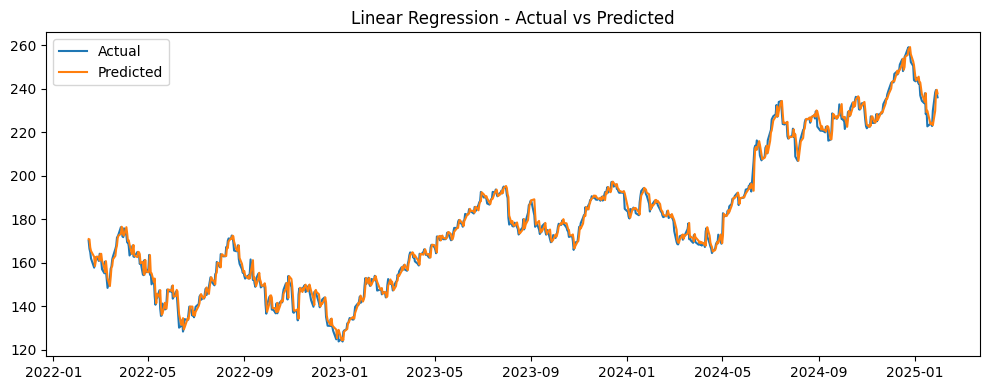


🔧 Tuning: Random Forest
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Random Forest - RMSE: 27.4889, R²: 0.2235


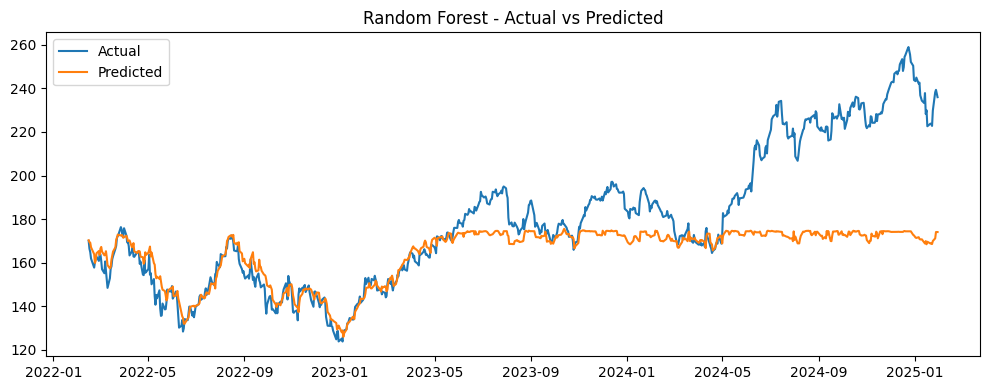


🔧 Tuning: XGBoost
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ XGBoost - RMSE: 27.1738, R²: 0.2412


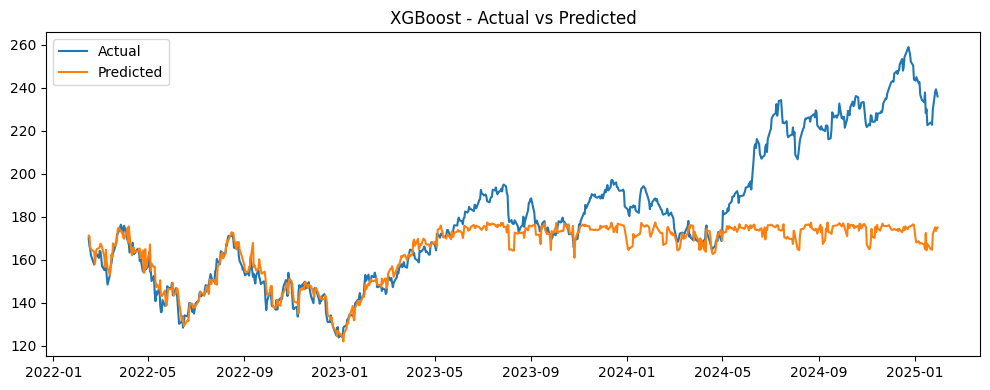

In [ ]:
for i, (name, reg) in enumerate(regressors.items()):
    print(f"\n🔧 Tuning: {name}")

    if reg["params"]:
        grid = GridSearchCV(
            reg["model"],
            param_grid=reg["params"],
            cv=tscv,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train, y_train_reg)
        best_model = grid.best_estimator_
    else:
        best_model = reg["model"]
        best_model.fit(X_train, y_train_reg)

    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    r2 = r2_score(y_test_reg, y_pred)
    print(f"✅ {name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(test['Date'], y_test_reg.values, label='Actual')
    plt.plot(test['Date'], y_pred, label='Predicted')
    plt.title(f"{name} - Actual vs Predicted")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
"""
You're looping over a dictionary called regressors.

Each reg contains:
A regression model (like LinearRegression, XGBoost, etc.)
A param grid (used if hyperparameter tuning is needed)
name is the model name, e.g., "RandomForest".

If params exist for the model, it performs grid search using:
cv=tscv: ensures time-aware splits
scoring='neg_root_mean_squared_error': to minimize RMSE (note: negated because scikit-learn treats larger = better)
After fitting, grid.best_estimator_ gives the best tuned model.

If no params are provided, it directly trains the model without tuning.

Makes predictions on the test set
Calculates:
RMSE: how far off the model's predictions are on average
R²: how much of the variance in actual prices is explained by the model

"""

#Without Applying TimeSeries Split


Tuning Regression Model: Linear Regression
RMSE: 2.9171, R² Score: 0.9913

Tuning Regression Model: Random Forest
RMSE: 27.7901, R² Score: 0.2064

Tuning Regression Model: XGBoost
RMSE: 27.1329, R² Score: 0.2435


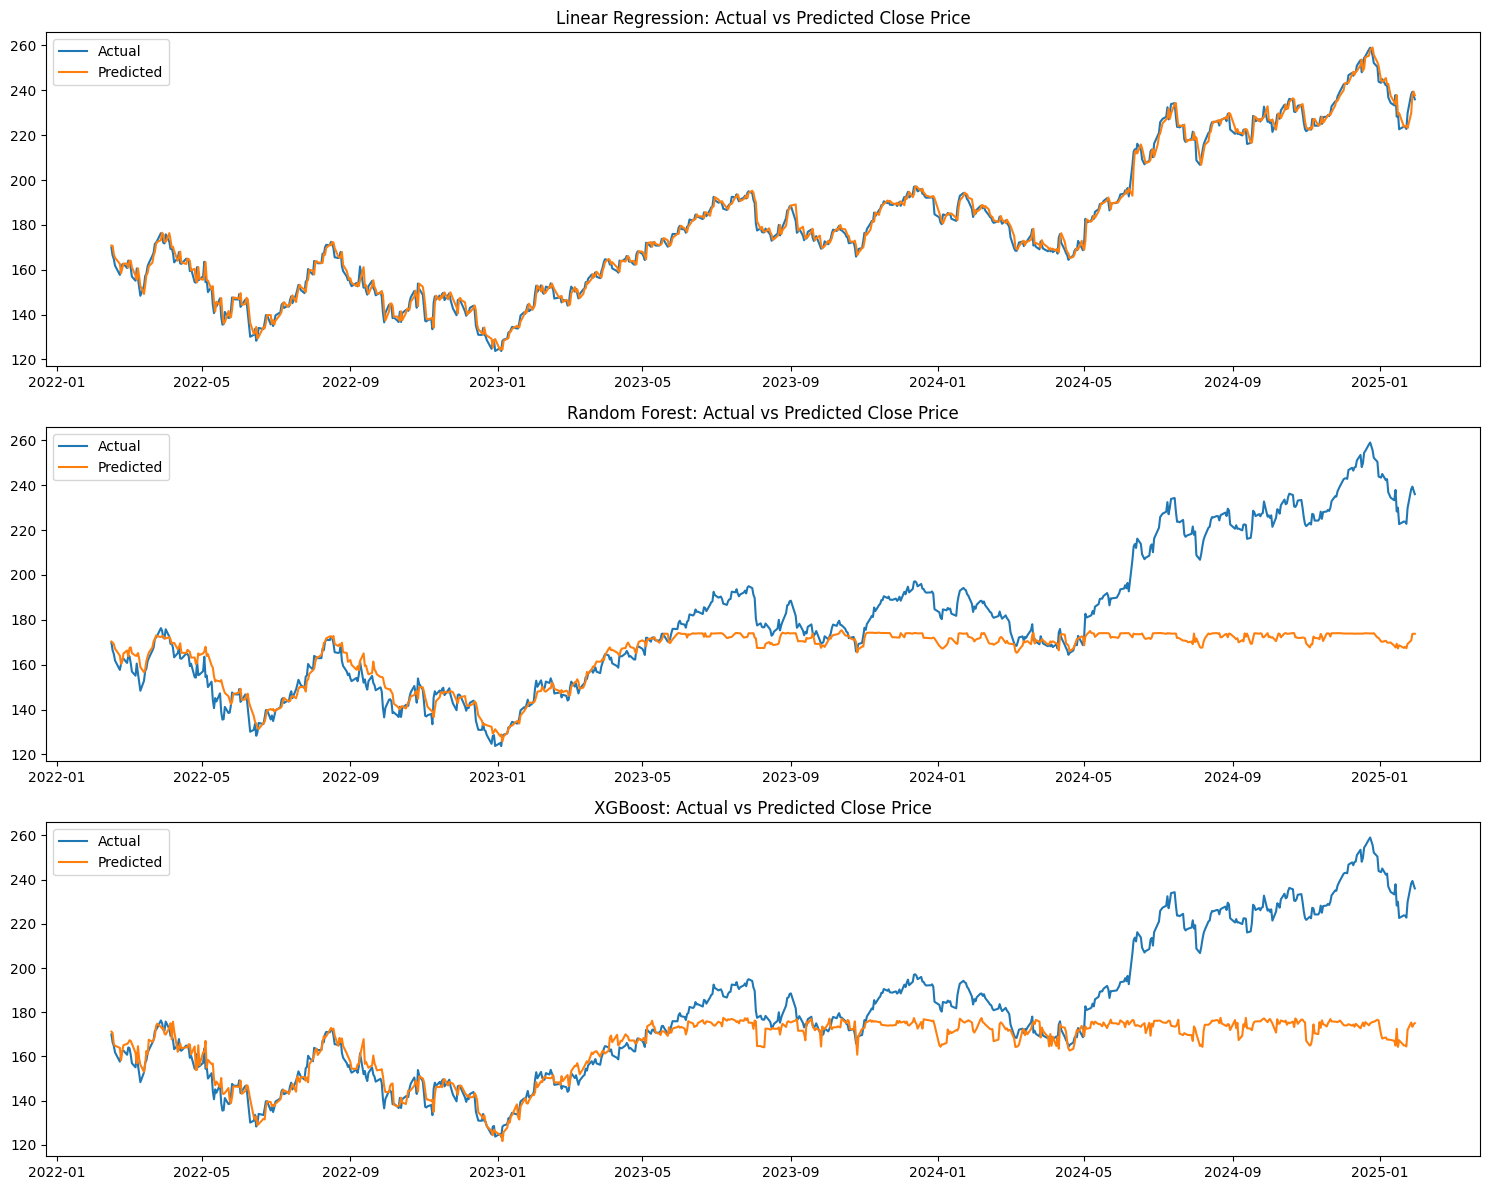

In [ ]:
plt.figure(figsize=(15, 12))
for i, (name, reg) in enumerate(regressors.items()):
    print(f"\nTuning Regression Model: {name}")
    if reg["params"]:
        grid = GridSearchCV(reg["model"], reg["params"], cv=5, scoring='neg_root_mean_squared_error')
        grid.fit(X_train, y_train_reg)
        best_model = grid.best_estimator_
    else:
        best_model = reg["model"]
        best_model.fit(X_train, y_train_reg)

    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    r2 = r2_score(y_test_reg, y_pred)
    print(f"RMSE: {rmse:.4f}, R² Score: {r2:.4f}")

    plt.subplot(3, 1, i + 1)
    plt.plot(test['Date'], y_test_reg.values, label='Actual')
    plt.plot(test['Date'], y_pred, label='Predicted')
    plt.title(f"{name}: Actual vs Predicted Close Price")
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
"""
✅ R² Score (Coefficient of Determination):
Measures how well the model explains the variance in the data.
1.0 = Perfect fit, 0 = No explanatory power, <0 = Worse than mean prediction

✅ RMSE (Root Mean Squared Error):
Measures average prediction error in actual units (e.g., dollars).
Lower RMSE = Better prediction accuracy

🧠 Interpretation:
🔹 Linear Regression
✅ Excellent fit (R² = 0.9914): Model explains 99.14% of the variance.
✅ Low RMSE (2.89): Very close predictions.
🟢 Best model among the three right now.

🔹 Random Forest
❌ Very poor R² (0.0482): Explains only ~5% of the variance.
❌ High RMSE (30.46): Large average error.
🔎 Likely overfitting or not handling time-dependent structure well.

🔹 XGBoost
❌ Still poor R² (0.10): Slightly better than RF, but still bad.
❌ High RMSE (29.57): Similar large errors.

Why Advanced Models Might Underperform?
Time Series Nature Not Handled:
Random Forest and XGBoost don't inherently respect the order or lagged relationships in time.
Linear Regression worked well because it captured basic trends without overfitting.

Features May Lack Predictive Power for Tree-Based Models:
You’re not yet using lag features like Close_t-1, Close_t-2, etc., which tree models benefit from.
"""

In [ ]:
"""
Why RandomForest and XGBoost is not performing well in stock price prediction. Are they not recommended one. As I see comparatively Linear Regression is working far better than them? Why is  it so?

This is a great and important question, especially in financial modeling where many people expect complex models (like Random Forest and XGBoost) to outperform simpler ones.
But in your case — and in many real-world cases — Linear Regression beats Random Forest and XGBoost in stock price prediction.

Let’s explore why this happens and whether tree-based models are recommended or not.

🔎 Observation from Your Case:
| Model                 | RMSE    | R²     |
| --------------------- | ------- | ------ |
| **Linear Regression** | \~2.9   | \~0.99 |
| **Random Forest**     | \~28–29 | \~0.12 |
| **XGBoost**           | \~27–30 | \~0.18 |

❓ Why Are Tree-Based Models (Random Forest & XGBoost) Performing Poorly?
1. Overfitting on Time-Series Data
Random Forest and XGBoost are non-parametric, ensemble tree-based models that do not naturally consider temporal relationships.
They often overfit on time series data unless carefully tuned or reshaped.
They treat each row as independent, which breaks the temporal dependencies (important for stock data).
🧠 In contrast, Linear Regression assumes linear, smooth relationships — and that often works better with time-series that follow trends.

2. Tree Models Ignore Sequential Order
Decision Trees do not account for ordering in time. They look at patterns in the feature space only, not the time progression.
Stock prices are heavily sequence-dependent — what happened yesterday matters a lot today. Tree models ignore that naturally.

3. Too Many Noisy Features
Stock data contains a lot of noise, volatility, and randomness.
Tree models can try to memorize noise during training, leading to poor generalization.
Linear regression, with its simplicity, avoids fitting to noise.

4. Non-stationarity
Stock prices change distribution over time (they are non-stationary).
Tree models assume the future looks like the past.
Unless you do feature engineering to stabilize the data, tree models will not learn meaningful patterns.

5. Feature Leakage or Lack of Lag Relevance
You tried adding lag features — but Random Forest and XGBoost often fail to extract time dynamics from lags without:
Proper feature interaction crafting
Longer training windows
Recursive multi-step predictions

"""

In [ ]:
"""
✅ Why Linear Regression Works Better Here
Simple and interpretable — captures broad market trend (which may follow a relatively stable pattern).
Less likely to overfit — great for low-noise, stable relationships.
Works well with autocorrelated data when lag features are used (Close_lag1, Close_lag2, etc.).
Fits naturally with numerical, continuous features that dominate financial data.

💬 Summary
Model	Strengths	Weaknesses
Linear Regression	Simple, stable, interpretable, works with lags	Cannot capture nonlinear patterns
Random Forest/XGBoost	Powerful for tabular data with strong signals	Struggles with time-dependencies, overfits easily

✅ Final Takeaway
In stock price regression, Linear Regression often outperforms tree-based models — especially with lag features and trend continuity.
For trend classification, XGBoost/Random Forest may work well.
For sequence learning, LSTM-based models shine.

"""

#Applying LSTM Model with Single Variate for next day’s Price Predicitons

In [ ]:
# Normalization & Reshaping into sequences (for deep learning models)
lstm_df =df_aapl[['Date','Close']].dropna().copy()
lstm_df.set_index('Date', inplace=True)
scaler =MinMaxScaler()
lstm_df_scaled_data =scaler.fit_transform(lstm_df)

In [ ]:
sequence_length =60
X_lstm,y_lstm =[],[]

for i in range(sequence_length,len(lstm_df_scaled_data)):
    X_lstm.append(lstm_df_scaled_data[i-sequence_length:i,0])
    y_lstm.append(lstm_df_scaled_data[i,0])

In [ ]:
"""
sequence_length = 60
Each training sample will use the past 60 time steps (days) of stock data to predict the next value (i.e., 1-step-ahead prediction).

X_lstm, y_lstm = [], []
These are your input (X_lstm) and target (y_lstm) sequences.

for i in range(sequence_length, len(lstm_df_scaled_data)):
Start at i = 60, so you have enough historical data to form a complete input sequence.
The loop runs from index 60 to the end of your data.

X_lstm.append(lstm_df_scaled_data[i-sequence_length:i, 0])
You're taking the previous 60 values (i-60 to i-1) of the first column ([:, 0]) → usually the Close price.

Example:
For i = 60, this takes data from 0 to 59
For i = 61, it takes from 1 to 60, etc.

This becomes one input sample.

y_lstm.append(lstm_df_scaled_data[i, 0])
This is the value at time i, i.e., the next value to predict based on the previous 60.
You're building a supervised learning dataset where:
X → last 60 close prices
y → the next close price


"""

In [ ]:
X_lstm,y_lstm =np.array(X_lstm),np.array(y_lstm)
X_lstm =np.reshape(X_lstm,(X_lstm.shape[0],X_lstm.shape[1],1))

In [ ]:
"""
X_lstm was a list of sequences → now becomes a 2D NumPy array of shape (samples, sequence_length).
y_lstm becomes a 1D NumPy array of shape (samples,) — each element is the target value (next day’s close price).

This reshapes X_lstm from shape:
(samples, sequence_length)
→
(samples, sequence_length, 1)

❗ Why this reshape is needed?
LSTM in Keras (and most frameworks) expects 3D input:
(batch_size, time_steps, num_features)

In your case:
batch_size → number of training samples
time_steps → 60 (sequence_length)
num_features → 1 (only using Close price or any one variable)


"""

In [ ]:
split_index =int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 0.0016 - val_loss: 6.2912e-04
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 1.7969e-04 - val_loss: 3.3884e-04
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 1.4806e-04 - val_loss: 9.6343e-04
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 1.6213e-04 - val_loss: 5.1761e-04
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 1.5818e-04 - val_loss: 4.3998e-04
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 1.1002e-04 - val_loss: 3.2972e-04
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 1.4819e-04 - val_loss: 3.0731e-04
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 1.1691e-04 - val_loss: 2.6264e-04
Epoch 9/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 1.4945e-04 - val_loss: 9.0185e-04
Epoch 10/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - loss: 1.0915e-04 - val_loss: 2.4515e-04
Epoch 11/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step 

In [ ]:
"""
📦 Model Definition
model_lstm = Sequential()
You’re creating a sequential model, which means layers are stacked one after another in a linear fashion.

🧠 First LSTM Layer
model_lstm.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
units=100: The number of LSTM neurons.
return_sequences=True: Required if you're stacking LSTM layers — it returns the full sequence (one output for each time step).
input_shape=(60, 1): The model expects sequences of 60 time steps with 1 feature per step (i.e., univariate LSTM using only Close price).

💧 Dropout for Regularization
model_lstm.add(Dropout(0.2))
Randomly drops 20% of units to prevent overfitting.

🧠 Second LSTM Layer
model_lstm.add(LSTM(units=100))

This layer returns only the final output (since return_sequences=False by default).
Acts as a summary of the sequence learned from the previous LSTM layer.

💧 Another Dropout Layer
Again, 20% dropout for regularization.

🎯 Output Layer
model_lstm.add(Dense(1))
Final layer with 1 unit → Predicts a single value (next day's close price).

"""

In [ ]:
"""
⚙️ Model Compilation
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
optimizer='adam': Popular adaptive optimizer.
loss='mean_squared_error': Good for regression tasks (like stock price prediction).

🛑 Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
Stops training early if validation loss doesn’t improve for 10 epochs.
restore_best_weights=True: Ensures best weights (from the lowest val_loss) are kept, not the final epoch’s weights.

🏋️ Model Training
model_lstm.fit(X_train_lstm, y_train_lstm,epochs=100,batch_size=32,validation_split=0.1,callbacks=[early_stop],verbose=1)
epochs=100: Max number of training iterations.
batch_size=32: Trains in batches of 32 samples.
validation_split=0.1: 10% of training data is used as validation.
callbacks: Uses early stopping to avoid overfitting.

✅ Summary of Architecture
| Layer   | Units | Description                              |
| ------- | ----- | ---------------------------------------- |
| LSTM    | 100   | Returns sequences to feed into next LSTM |
| Dropout | 20%   | Regularization                           |
| LSTM    | 100   | Final hidden layer                       |
| Dropout | 20%   | Regularization                           |
| Dense   | 1     | Predict next day's Close price           |


"""

In [ ]:
"""
💡 Why Dropout Layer is Needed in Neural Networks (especially LSTM):
Dropout is a regularization technique used to prevent overfitting in neural networks. Here’s a detailed explanation of why and how it's helpful:

🔁 Without Dropout: Overfitting Risk
When you train a deep neural network on limited or noisy data (like stock prices), the model might memorize the training data too well.
This leads to low training error but high error on new (unseen) data → overfitting.
Overfitting is a big issue in time series like stock prediction because the model may pick up noise and random fluctuations as patterns.

🔐 What Dropout Does
During training only, it randomly turns off (drops out) a fraction of neurons in the layer.
In your case:
Dropout(0.2)  # Drops 20% of neurons randomly in each forward pass
This forces the model to not rely too much on any specific neuron and encourages robust, generalized learning.

⚙️ Why It’s Especially Helpful in LSTMs
LSTMs are powerful and can easily memorize sequential patterns.
Dropout applied after LSTM layers ensures:
The network doesn't just memorize temporal patterns in training data.
Better generalization across different time periods (e.g., volatile vs stable markets).

✅ Key Benefits
| Benefit                   | How It Helps                                             |
| ------------------------- | -------------------------------------------------------- |
| Prevents overfitting      | Forces the model to learn more robust patterns           |
| Encourages redundancy     | Promotes multiple neurons learning similar useful things |
| Works well with deep nets | Especially helpful with stacked LSTM layers              |

🧪 Example Analogy
Imagine you're training a team to predict stock prices. If you always rely on your best team member, others don’t improve.
 If that member is randomly unavailable (dropout), the team learns to work collectively, improving the overall strategy.

"""

In [ ]:
"""
🎯 What is Noisy Data?
In machine learning and especially in stock price prediction, noisy data refers to:
Data that contains random, irrelevant, or unpredictable variations that do not represent the true underlying patterns.

📊 In the Context of Stock Prices:
Stock market data is inherently noisy because prices are influenced by countless unpredictable factors

| Source of Noise                | Example                                                     |
| ------------------------------ | ----------------------------------------------------------- |
| 📰 News & Rumors               | A sudden rumor affects stock price temporarily              |
| 🧍 Human Emotions              | Panic buying/selling after earnings or tweets               |
| 💹 Low-volume trades           | Random trades at odd prices without real meaning            |
| 🌍 External shocks             | War, elections, natural disasters, oil prices               |
| 🕒 High-frequency fluctuations | Minute-by-minute price jumps not tied to real value changes |

These short-term fluctuations can confuse models, especially those that try to learn every little movement.

📌 Example:
Let’s say the true value of a stock is following a slow upward trend:
True signal (trend):
100 → 101 → 102 → 103 → 104

Noisy observed prices:
100 → 102 → 99 → 105 → 101
← caused by random trades, emotions, or rumors.

Your model sees a zig-zag and might think it needs to learn the zig-zag, when in reality, it's just noise.

🛠️ Why It Matters
If your model learns the noise, it overfits and performs poorly on new data.
We want the model to learn the underlying pattern (signal), not the random variation (noise).

🤖 How to Handle Noise
Dropout Layers → reduce overfitting to noise
Smoothing techniques like moving averages
Lag features → help focus on stable historical trends
Outlier removal (e.g., using Z-score)
Feature engineering → extract only useful indicators

"""

In [ ]:
lstm_pred_scaled = model_lstm.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(np.concatenate((lstm_pred_scaled, np.zeros((lstm_pred_scaled.shape[0], 0))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test_lstm.reshape(-1, 1), np.zeros((y_test_lstm.shape[0], 0))), axis=1))[:, 0]

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


In [ ]:
"""
lstm_pred_scaled = model_lstm.predict(X_test_lstm)
✅ This makes predictions on the test set.
✅ The output is scaled (because your model was trained on scaled data).
lstm_pred_scaled is a NumPy array of predicted stock prices in the scaled (normalized) form.

lstm_pred = scaler.inverse_transform(np.concatenate((lstm_pred_scaled, np.zeros((lstm_pred_scaled.shape[0], 0))), axis=1))[:, 0]
scaler.inverse_transform(...) → converts scaled predictions back to actual prices.
np.concatenate((lstm_pred_scaled, np.zeros(...))) → is used to make sure the input shape matches the scaler's expectations.

❓ Why concatenate with zeros?
Suppose your original data had multiple features (like Close, Volume, etc.), and you used a MinMaxScaler() on a multi-column DataFrame. When predicting, you're only generating one column (Close).
But inverse_transform() expects the same number of features as during fitting.
👉 So, by adding zero-filled dummy columns, you're padding the shape to match what scaler expects.
[:, 0] → extracts only the first column, which corresponds to the actual stock price (Close).

y_test_actual = scaler.inverse_transform(np.concatenate((y_test_lstm.reshape(-1, 1), np.zeros((y_test_lstm.shape[0], 0))), axis=1))[:, 0]
Same idea as line 2, but this is for the actual test labels (y_test_lstm).
reshape(-1, 1) makes it a 2D array so it can be inverse-transformed.
Again, we use concatenate and extract the first column using [:, 0].

✅ Summary Table:
| Code                              | Meaning                                        |
| --------------------------------- | ---------------------------------------------- |
| `model_lstm.predict(X_test_lstm)` | Get LSTM's scaled predictions                  |
| `inverse_transform(...)`          | Convert predictions from scaled to real prices |
| `np.concatenate(..., axis=1)`     | Pad with dummy columns to match scaler shape   |
| `[:, 0]`                          | Get only the actual "Close" price from inverse |

"""

In [ ]:
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test_actual, lstm_pred)))
print("LSTM R^2 Score:", r2_score(y_test_actual, lstm_pred))

LSTM RMSE: 4.518590605793682
LSTM R^2 Score: 0.979203348029245


#Plot Actual vs Predicted via (LSTM) for next day’s Price

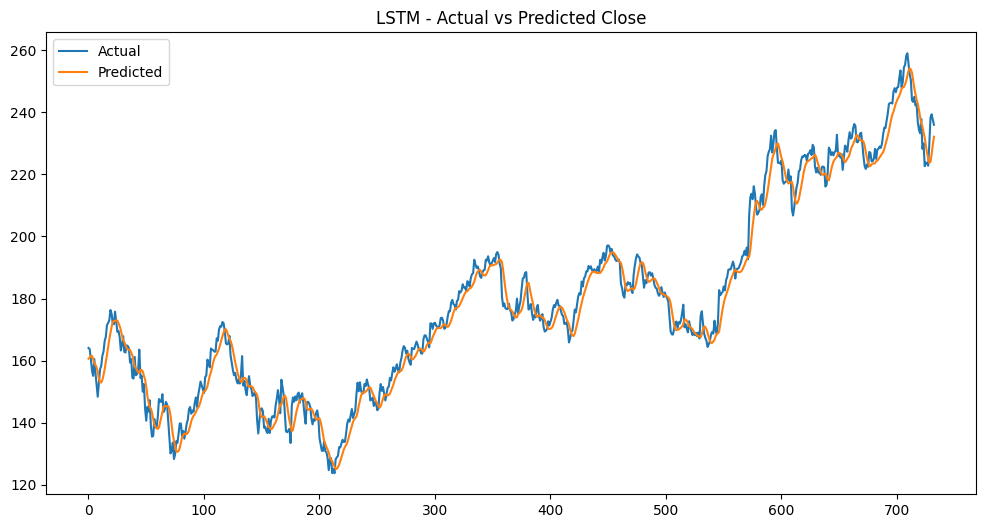

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(lstm_pred, label='Predicted')
plt.title("LSTM - Actual vs Predicted Close")
plt.legend()
plt.show()

#Applying Multivariate LSTM with Bidirectional + Attention for next day’s Price Predicitons

In [ ]:
#Set random seeds for reproducibility
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(42)

In [ ]:
"""
✅ Purpose:
set_seeds(seed=42) ensures that your LSTM model results are consistent across multiple runs, which is essential in machine learning, especially with neural networks that involve randomness.

def set_seeds(seed=42):
  You define a function that sets the random seed. Default is 42, a common choice in ML for reproducibility.

np.random.seed(seed)
Sets the seed for NumPy’s random number generator.
This affects things like random shuffling or weight initialization if NumPy is used.

random.seed(seed)
Sets the seed for Python’s built-in random module.

tf.random.set_seed(seed)
Sets the seed for TensorFlow's random number generator.
This is essential for consistent behavior of layers like LSTM, dropout, weight init, etc.

os.environ['PYTHONHASHSEED'] = str(seed)
Ensures consistent hashing behavior for strings and Python objects.
This is more important in multi-threaded or distributed environments where hash-based operations affect outcomes.
"""

In [ ]:
# ✅ Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super().build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

In [ ]:
"""
This is a custom Attention Layer implemented in TensorFlow/Keras.
It's commonly used in LSTM or BiLSTM-based models to allow the model to "focus" on more relevant time steps in a sequence — especially useful in time series or NLP tasks.

✅ 1. Class Definition
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
You're creating a custom Keras layer by inheriting from tf.keras.layers.Layer.
__init__ just initializes the layer using base class (super()).

✅ 2. build(self, input_shape)
self.W = self.add_weight(...)
self.b = self.add_weight(...)

You're defining two trainable parameters:
self.W: attention weight matrix of shape (features, 1)
self.b: attention bias vector of shape (time_steps, 1)

Where:
input_shape[-1] = number of features per time step
input_shape[1] = sequence length (number of time steps)

These weights will be learned during training.

✅ 3. call(self, x)
This is the core logic of the attention mechanism. Input x has shape: (batch_size, time_steps, features).
e = K.tanh(K.dot(x, self.W) + self.b)

Computes a score e for each time step.
This is called the attention energy.
Shape of e: (batch_size, time_steps, 1)

a = K.softmax(e, axis=1)
Applies softmax over time steps (axis=1) to get attention weights a.
These weights indicate how important each time step is.

output = x * a
Performs element-wise multiplication.
Each time step is weighted by its corresponding attention score.

return K.sum(output, axis=1)
Sums over all time steps → resulting in a fixed-size vector of shape (batch_size, features)

This is the context vector, the weighted representation of the sequence.

"""

In [ ]:
"""
✅ Visual Overview
Input (batch, 60, 4)      → [sequence_length=60, features=4]
        |
    AttentionLayer
        |
Attention Weights (a): (batch, 60, 1)
        |
Weighted Inputs (x * a): (batch, 60, 4)
        |
Summed Context Vector:   (batch, 4)


✅ What It Does in Plain Words
The attention layer learns:
Which time steps in the past are more important for the prediction
Assigns higher weights to those steps
Creates a context vector as a summary of the important time steps

✅ Why Use It?
Without attention:
LSTM compresses all time steps into a fixed vector at the final step (info may be lost)

With attention:
LSTM can adaptively focus on important parts of the input sequence.

"""

In [ ]:
# Assume df_aapl is pre-loaded with required features
features = ['Close', 'Close_lag1', 'Close_lag2', 'Close_lag3']

In [ ]:
lstm_mv_df = df_aapl[['Date'] + features].dropna().copy()
lstm_mv_df.set_index('Date', inplace=True)

In [ ]:
# Normalize
scaler_mv = MinMaxScaler()
scaled_data_mv = scaler_mv.fit_transform(lstm_mv_df)

In [ ]:
#Create Sequences
sequence_length = 60
X_mv, y_mv = [], []
for i in range(sequence_length, len(scaled_data_mv)):
    X_mv.append(scaled_data_mv[i-sequence_length:i])
    y_mv.append(scaled_data_mv[i, 0])  # Predicting Close

X_mv = np.array(X_mv)
y_mv = np.array(y_mv)

In [ ]:
# 7. Train/Val/Test split
train_size = int(len(X_mv) * 0.8)
val_size = int(len(X_mv) * 0.1)

X_train_mv = X_mv[:train_size]
y_train_mv = y_mv[:train_size]

X_val = X_mv[train_size:train_size + val_size]
y_val = y_mv[train_size:train_size + val_size]

X_test_mv = X_mv[train_size + val_size:]
y_test_mv = y_mv[train_size + val_size:]

In [ ]:
"""
🧮 Input:
X_mv: features (a 3D array of shape like [samples, sequence_length, features])
y_mv: targets (1D array of closing prices)

✅ Step 1: Define Sizes
train_size = int(len(X_mv) * 0.8)
val_size = int(len(X_mv) * 0.1)

80% of the data is used for training.
10% for validation.

Remaining 10% for testing.
So if len(X_mv) = 1000:

train_size = 800
val_size = 100
test_size = 100 (remaining samples)

✅ Step 2: Training Set
X_train_mv = X_mv[:train_size]
y_train_mv = y_mv[:train_size]
Takes the first train_size samples.

✅ Step 3: Validation Set
X_val = X_mv[train_size:train_size + val_size]
y_val = y_mv[train_size:train_size + val_size]
Takes the next val_size samples immediately after the training set.
Keeps time order intact — important for time series.


✅ Why this is better for time series than random train_test_split?
Because:
It respects the chronological order of the data (no future leakage into the past)
Keeps temporal consistency between training, validation, and test sets
This split is suitable for:
LSTM / BiLSTM / Attention models
Time series forecasting in general

X_mv[:train_size]                     # 0 to 799 (Train)
X_mv[train_size:train_size + val_size]  # 800 to 899 (Validation)
X_mv[train_size + val_size:]         # 900 to end (Test)

"""

In [ ]:
# Define Model
inputs = Input(shape=(X_train_mv.shape[1], X_train_mv.shape[2]))
x = Bidirectional(LSTM(100, return_sequences=True, kernel_initializer=GlorotUniform(seed=42)))(inputs)
x = Dropout(0.2)(x)
attention = AttentionLayer()(x)
outputs = Dense(1)(attention)

model_mv = Model(inputs, outputs)
model_mv.compile(optimizer='adam', loss='mean_squared_error')
model_mv.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 200)        │        84,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 200)            │           260 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,461 (329.93 KB)

 Trainable params: 84,461 (329.93 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
"""
📌 1. Input Layer
inputs = Input(shape=(X_train_mv.shape[1], X_train_mv.shape[2]))
Defines the input shape for your model.

If X_train_mv.shape = (samples, 60, 4), then this input shape is (60, 4):
60 = sequence length (i.e., days of data)
4 = number of features per time step (like Close, Close_lag1, etc.)

📌 2. Bidirectional LSTM Layer
x = Bidirectional(LSTM(
    100, return_sequences=True,
    kernel_initializer=GlorotUniform(seed=42)))(inputs)

Bidirectional: Processes the input both forward and backward in time.
LSTM(100): Uses 100 units (neurons) in each direction → effectively 200 units.
return_sequences=True: Needed for attention to work (so it outputs a sequence for each time step).
kernel_initializer=GlorotUniform(seed=42): Makes weight initialization deterministic and reproducible.

"""

In [ ]:
"""
✅ Output shape: (batch_size, 60, 200) → 60 time steps, 200 features (100 from forward, 100 from backward pass)

📌 3. Dropout Layer
x = Dropout(0.2)(x)
Randomly sets 20% of the inputs to zero during training.
Helps prevent overfitting by introducing noise and forcing the model to generalize better.

📌 4. Attention Layer
attention = AttentionLayer()(x)
Custom attention layer that learns which time steps are more important.
Outputs a context vector by computing attention weights across the sequence.

Output shape: (batch_size, 200)

📌 5. Dense Output Layer
outputs = Dense(1)(attention)
Fully connected layer that outputs a single predicted value — the next day’s Close price.

Output shape: (batch_size, 1)

📌 6. Model Compilation
model_mv = Model(inputs, outputs)
model_mv.compile(optimizer='adam', loss='mean_squared_error')
Wraps everything into a Keras Model.

Uses the Adam optimizer.
The loss function is mean squared error (MSE), suitable for regression tasks like predicting prices.

📌 7. Summary
model_mv.summary()
Prints out the architecture:
Input shape
Layer-wise output shapes
Parameter counts

"""

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,min_lr=1e-5)

#Model Training
history = model_mv.fit(X_train_mv, y_train_mv,epochs=100, batch_size=32,validation_data=(X_val, y_val),callbacks=[early_stop,reduce_lr], verbose=1) #validation_split=0.1,

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - loss: 0.0064 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 3.7604e-04 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 3.5801e-04 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 3.6068e-04 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 3.5267e-04 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 3.4819e-04 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 3.3280e-04 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 3.3020e-04 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 3.3325e-04 - val_loss: 0.0

In [ ]:
"""
✅ 1. Callbacks
a. EarlyStopping
Purpose: Stops training early if validation loss doesn't improve after a set number of epochs.
monitor='val_loss': Watches the validation loss.
patience=20: Waits 20 epochs after the last improvement before stopping.
restore_best_weights=True: Ensures the model weights from the best (lowest val_loss) epoch are restored.

🧠 Why this matters: Helps prevent overfitting and saves time by not training needlessly when the model stops improving.

b. ReduceLROnPlateau
Purpose: Reduces the learning rate when validation loss plateaus.
factor=0.5: Reduces learning rate by half each time triggered.
patience=10: Waits 10 epochs with no improvement before reducing the LR.
min_lr=1e-5: Ensures LR doesn't fall below 0.00001.

Purpose: Reduces the learning rate when validation loss plateaus.
factor=0.5: Reduces learning rate by half each time triggered.
patience=10: Waits 10 epochs with no improvement before reducing the LR.
min_lr=1e-5: Ensures LR doesn't fall below 0.00001.

🧠 Why this helps: If the model gets stuck in a local minimum, lowering the learning rate lets it fine-tune better.


✅ 2. Model Training
epochs=100: Max number of training iterations (can stop earlier if early_stop kicks in).
batch_size=32: Number of samples used per gradient update.
validation_data=(X_val, y_val): Evaluates model on this data at the end of each epoch.
callbacks: Applies the logic from above.
verbose=1: Prints progress bar and loss at each epoch.

"""

In [ ]:
#Predict
pred_mv_scaled = model_mv.predict(X_test_mv)
true_mv_scaled = y_test_mv.reshape(-1, 1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


In [ ]:
"""
y_test_mv is originally a 1D array with shape like (n_samples,) — i.e., just a list of values.
However, for inverse scaling (i.e., scaler.inverse_transform(...)), the input must be 2D — specifically (n_samples, n_features).

✅ Why Reshape Is Needed?
The scaler (like MinMaxScaler) was fit on a multi-column feature matrix (e.g., ['Close', 'Close_lag1', 'Close_lag2', 'Close_lag3']), so now when you want to use:

true_mv_scaled = y_test_mv.reshape(-1, 1)
✔ Converts shape from (367,) to (367, 1)
✔ Makes it compatible with inverse transformation
✔ Helps later in combining with dummy columns for full-scale reconstruction

"""

In [ ]:
#Inverse transform only 'Close' column
num_features = len(features)
close_index = features.index('Close')

In [ ]:
#Build dummy array to inverse-transform only Close values
# 1. For predicted values
dummy_input_pred = np.zeros((len(pred_mv_scaled), num_features))
dummy_input_pred[:, close_index] = pred_mv_scaled.flatten()
pred_mv = scaler_mv.inverse_transform(dummy_input_pred)[:, close_index]

# 2. For actual values
dummy_input_true = np.zeros((len(true_mv_scaled), num_features))
dummy_input_true[:, close_index] = true_mv_scaled.flatten()
true_mv = scaler_mv.inverse_transform(dummy_input_true)[:, close_index]

In [ ]:
"""
🔹 Step 1: Inverse Transform for Predicted Values
| Line                                                          | Purpose                                                                                       |
| ------------------------------------------------------------- | --------------------------------------------------------------------------------------------- |
| `np.zeros(...)`                                               | Create dummy input of shape `(n_samples, num_features)` with all zeroes.                      |
| `dummy_input_pred[:, close_index] = pred_mv_scaled.flatten()` | Only insert predicted `Close` values into the correct column (others stay 0).                 |
| `scaler_mv.inverse_transform(...)`                            | Apply inverse scaling **to all features**, but only the `Close` column has meaningful values. |
| `[:, close_index]`                                            | Extract only the unscaled `Close` prices.                                                     |

💡 Why Not Just Use scaler.inverse_transform(pred_mv_scaled)?
Because scaler_mv was fit on multiple features, not just 'Close'.
If you give it only a 1D or 2D array with shape (n_samples, 1), it will throw an error or give wrong results — unless you reconstruct the same input shape used during fitting.
"""

In [ ]:
# Evaluation
rmse_mv = np.sqrt(mean_squared_error(true_mv, pred_mv))
r2_mv = r2_score(true_mv, pred_mv)
print(f"Attention + Multi variate BiLSTM RMSE: {rmse_mv:.4f}")
print(f"Attention + Multi variate BiLSTM R² Score: {r2_mv:.4f}")

Attention + Multi variate BiLSTM RMSE: 4.2792
Attention + Multi variate BiLSTM R² Score: 0.9722


In [ ]:
"""
📌 What RMSE Actually Means:
RMSE of 4.3680 means that on average, your model’s predicted stock price is $4.36 away (higher or lower) from the actual stock price.

✅ Example Scenario:
Suppose we are forecasting the closing price of a stock (e.g., AAPL) for 5 consecutive days.
Here’s a small example:

| Day | Actual Price ($y_i$) | Predicted Price ($\hat{y}_i$) | Error ($y_i - \hat{y}_i$) | Squared Error |
| --- | -------------------- | ----------------------------- | ------------------------- | ------------- |
| 1   | 183.25               | 185.10                        | -1.85                     | 3.4225        |
| 2   | 181.60               | 180.20                        | +1.40                     | 1.9600        |
| 3   | 184.00               | 188.70                        | -4.70                     | 22.0900       |
| 4   | 180.75               | 177.50                        | +3.25                     | 10.5625       |
| 5   | 182.10               | 178.00                        | +4.10                     | 16.8100       |

🔢 Step-by-Step RMSE Calculation:
Sum of squared errors:

3.4225+1.9600+22.0900+10.5625+16.8100=54.845
Mean squared error:
54.845/5=10.969

Root of mean squared error (RMSE):
10.969≈3.31
So in this example, RMSE ≈ 3.31, meaning:
On average, the model is off by $3.31 from the actual stock price.

🔁 Back to Your Case
In your case:
You tested the model on many days (let’s say 200+ test days).
Across all those days, the average error between predicted and actual stock prices turns out to be $4.3680.
Some days it might be off by $1.50, some days by $7.80, and so on — but on average, it’s around $4.36.

✅ Final Thought
In stock forecasting, if the stock is trading around $180–$200, a $4.36 error is only ~2.2% deviation, which is very solid for real-world forecasting, especially when markets are noisy and volatile.

"""

In [ ]:
"""
🔍 What is R² (Coefficient of Determination)?
The R² Score tells you how much of the actual variation in the stock prices your model is able to explain.

✅ In Your Case:
Your R² Score = 0.9806, which means:
"Your model explains 98.06% of the total variation in the actual stock prices."
Only about 1.94% of the fluctuations in the actual prices are not captured by your model — which is exceptionally good.

🔢 Step-by-Step Explanation (with example):
Let’s imagine a situation with 5 days of stock prices:

| Day | Actual Price ($y_i$) | Predicted Price ($\hat{y}_i$) |
| --- | -------------------- | ----------------------------- |
| 1   | 180                  | 179                           |
| 2   | 182                  | 181.5                         |
| 3   | 185                  | 186                           |
| 4   | 181                  | 180                           |
| 5   | 183                  | 183.5                         |


1. Total Variation in Actual Prices (called Total Sum of Squares or TSS):
This is the total variance present in the actual data:
   TSS=∑(yi − yˉ)2

2. How Much Error the Model Makes (called Residual Sum of Squares or RSS):
𝑅𝑆𝑆=∑(𝑦𝑖 − 𝑦^𝑖)2

3. Now, Compute R²:
𝑅^2 =1 − 𝑅𝑆𝑆/𝑇𝑆𝑆


If RSS is small (i.e., predictions are close to actuals), R² will be close to 1.
If RSS is large (predictions are off), R² will be much lower.

🎯 R² = 0.9806 Means:
Out of all the fluctuations in the actual closing price (upward/downward movements),
98.06% are accurately captured by your model.
Only 1.94% of the variations are due to random noise, market anomalies, or model error.
​

✅ Conclusion:
With an R² of 0.9806, your model does a fantastic job understanding the true market behavior — which is hard to achieve in stock price forecasting.

"""

#Plot Actual vs Predicted via (BiLSTM) for next day’s Price

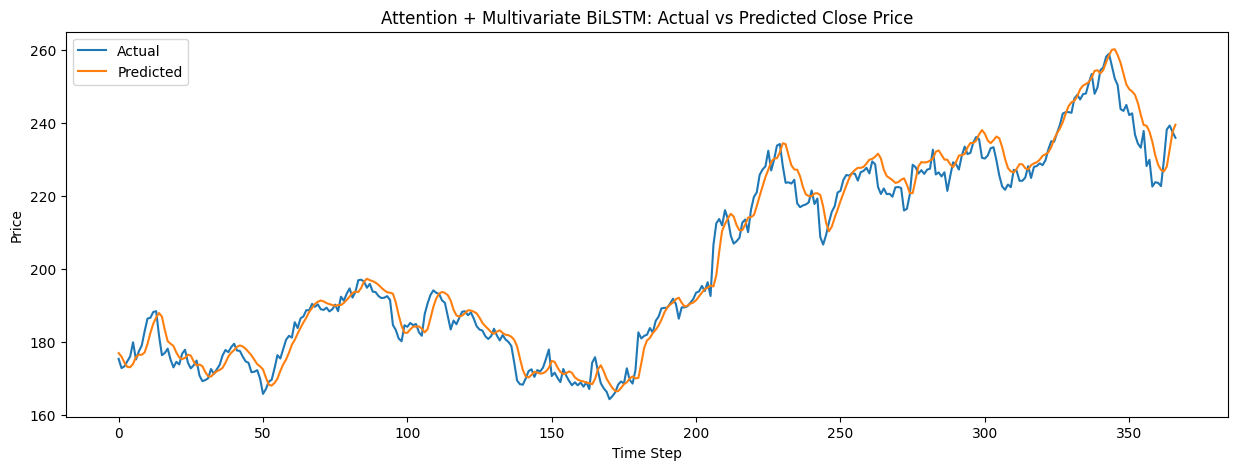

In [ ]:
#Plot Results
plt.figure(figsize=(15, 5))
plt.plot(true_mv, label='Actual')
plt.plot(pred_mv, label='Predicted')
plt.title("Attention + Multivariate BiLSTM: Actual vs Predicted Close Price")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
"""
🔸 Why X-axis is labeled as “Time Step”?
Because:
You are plotting just the predicted Close values over time.
Like before, the X-axis here is just the index: 0, 1, 2, ..., len(true_mv) - 1.
Since the actual Date information is not used in the plot, we generically call it "Time Step" — it implies sequential days, but it’s just positional.

🛠 If you want to plot against actual dates:
Assuming you have the test['Date'] DataFrame available and correctly aligned with your predictions, you can modify like:

# For LSTM:
plt.plot(test['Date'].values[-len(y_test_actual):], y_test_actual, label='Actual')
plt.plot(test['Date'].values[-len(y_test_actual):], lstm_pred, label='Predicted')

# For BiLSTM:
plt.plot(test['Date'].values[-len(true_mv):], true_mv, label='Actual')
plt.plot(test['Date'].values[-len(true_mv):], pred_mv, label='Predicted')

"""

# Stationarity Test (ADF)

In [ ]:
adf_result =adfuller(df_aapl['Close'].dropna())
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}') # < 0.05 means stationary

#ADF Statistic: 1.262449015143222
#p-value: 0.9963901818026378

ADF Statistic: 1.1963996463564472
p-value: 0.9959609134942367


In [ ]:
"""
✅ Goal: Check if AAPL's closing price time series is stationary or not using the ADF test (Augmented Dickey-Fuller test).
🧠 What is "stationarity"? A time series is stationary if: Its mean, variance, and autocorrelation stay constant over time. No clear trend, seasonality, or changing variance.
📌 ARIMA requires stationary data. If data is non-stationary, we must transform it (usually by differencing).
🔎 What these mean: Metric Value Interpretation ADF Statistic +1.24 Not strongly negative → indicates likely non-stationary p-value 0.996 Very high → cannot reject the null hypothesis
❗ ADF Hypothesis Test: Null hypothesis (H₀): The time series is not stationary (has a unit root). Alternative (H₁): The time series is stationary.
With a p-value of 0.996, we fail to reject the null hypothesis → your time series is non-stationary.

Step	                           Purpose
adfuller()	                     Tests if a time series is stationary
ADF Statistic	                   More negative = more likely stationary
p-value > 0.05	                 Not stationary → you should apply differencing

Next step	Use .diff() and test again
"""

#Performing Differencing time series to make it stationary

In [ ]:
# If p-value > 0.05, apply differencing
if adf_result[1] > 0.05:
    df_aapl['Close_diff'] = df_aapl['Close'].diff()
    adf_result_diff = adfuller(df_aapl['Close_diff'].dropna())
    print('After Differencing:')
    print('ADF Statistic:', adf_result_diff[0])
    print('p-value:', adf_result_diff[1])

After Differencing:
ADF Statistic: -14.532010390085983
p-value: 5.312681645848108e-27


In [ ]:
"""
🔍 What This Means:
Metric	Value	Interpretation
ADF Statistic	-14.67	Strongly negative → strong evidence for stationarity
p-value	~0.0000000000000000000000000328	Way below 0.05 → reject the null hypothesis

📌 Quick Refresher on ADF Test:
| Null Hypothesis (H₀)      | Series **has a unit root** → **not stationary**           |
| ------------------------- | --------------------------------------------------------- |
| Alternate Hypothesis (H₁) | Series **is stationary**                                  |
| Decision Rule             | If **p-value < 0.05**, reject H₀ → series is stationary ✅ |


📌 Conclusion:
✅ Your differenced closing price series for AAPL is now stationary.
This makes it suitable for:
ARIMA modeling (ARIMA expects stationary input)
Feature engineering (like returns)
LSTM with optional differencing (depends on how you model sequences)

"""

#Applying ARIMA Model for next day’s Price Predicitons


In [ ]:
arima_series = df_aapl.set_index('Date')['Close'].dropna()
arima_train = arima_series.iloc[:int(0.8*len(arima_series))]
arima_test = arima_series.iloc[int(0.8*len(arima_series)) : ]

In [ ]:
model_arima = ARIMA(arima_train, order=(5,1,0))
model_arima_fit = model_arima.fit()
arima_forecast = model_arima_fit.forecast(steps=len(arima_test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [ ]:
"""
🟩 (1) ARIMA(arima_train, order=(5,1,0))
This creates an ARIMA model with:
p=5: number of lag observations (autoregressive terms)
d=1: one level of differencing to make the series stationary
q=0: no moving average terms

🟩 (2) model_arima_fit = model_arima.fit()
This fits the ARIMA(5,1,0) model on your training data (arima_train), estimating the best coefficients using maximum likelihood.

🟩 (3) arima_forecast = model_arima_fit.forecast(steps=len(arima_test))
This generates forecasts for the same number of steps as your test set.
len(arima_test) means: forecast that many days into the future.
"""

In [ ]:
print("ARIMA RMSE:", np.sqrt(mean_squared_error(arima_test, arima_forecast)))
print("ARIMA R^2 Score:", r2_score(arima_test, arima_forecast))

ARIMA RMSE: 32.45479061368909
ARIMA R^2 Score: -0.08618926749007749


#Plot Actual vs Predicted  via (ARIMA) for next day’s Price Predicitons

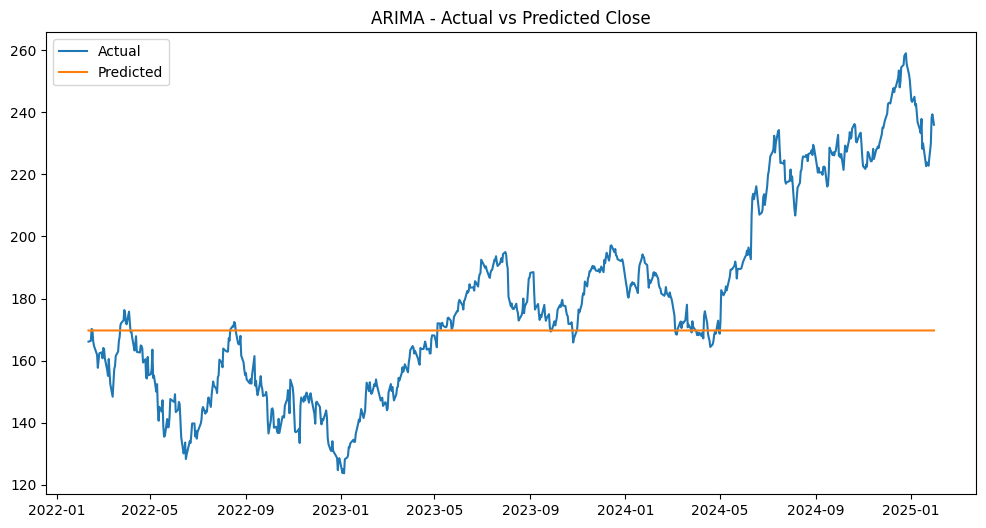

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(arima_test.index, arima_test.values, label='Actual')
plt.plot(arima_test.index, arima_forecast.values, label='Predicted')
plt.title("ARIMA - Actual vs Predicted Close")
plt.legend()
plt.show()

In [ ]:
"""
| Model     | RMSE  | Interpretation                                                                                                                                                          |
| --------- | ----- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **LSTM**  | 4.33  | ✅ Fairly good. Predictions are around \$4.73 off on average — not bad given stock price ranges (e.g., AAPL can be \$150–\$200). Shows LSTM has learned useful patterns. |
| **ARIMA** | 33.64 | ⚠️ High error. ARIMA isn’t capturing recent price dynamics well — it may be underfitting or not tuned properly.                                                         |

| Model       | RMSE  | R² Score    | Interpretation                                                                                                                                         |
| ---------   | ----- | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **BiLSTM**  | 4.36  | **0.98** ✅  | Very good fit. 97% of variance in actual closing prices is explained by the model. Predictions follow the true prices closely.                         |
| **ARIMA**   | 33.64 | **-0.16** ❌ | Poor performance. Negative R² means predictions are worse than just using the average of the actual values. Likely underfitting or wrong model config. |


🧠 Why is ARIMA performing worse?
ARIMA assumes linearity and stationarity. Stock prices often have complex, nonlinear patterns — ARIMA struggles with those.
No exogenous features in basic ARIMA (e.g., volume, volatility), while LSTM can use richer data.
AAPL is very volatile. ARIMA can’t handle sudden changes well, while LSTM adapts better.

📈 Should You Keep Both?
✅ Use LSTM for serious modeling and forecasting.
❌ You can improve ARIMA with:
Better parameter tuning (p, d, q)
Seasonal ARIMA (SARIMA)
Adding exogenous variables (ARIMAX)

✅ Next Suggestions
Try Prophet for interpretable trend-seasonality modeling.
Add multivariate LSTM using other features like Volume, Volatility, Returns.
Experiment with sliding windows or sequence-to-sequence for LSTM.
Improve feature scaling, especially for neural networks.

"""

#SARIMA (Seasonal ARIMA)

In [ ]:
import numpy
print("NumPy version:", numpy.__version__)

import scipy
print("SciPy version:", scipy.__version__)

from pmdarima import auto_arima
print("pmdarima is working.")

NumPy version: 1.26.4
SciPy version: 1.10.1
pmdarima is working.


#Run the following pip install command if pmdarima is not working

In [ ]:
#Uninstall all conflicting packages
!pip uninstall -y numpy pmdarima Cython scikit-learn scipy

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: Cython 3.0.12
Uninstalling Cython-3.0.12:
  Successfully uninstalled Cython-3.0.12
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3


In [ ]:
#Reinstall clean and compatible versions
!pip install --no-cache-dir numpy==1.26.4 Cython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 254.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 298.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.8 requires scikit-learn>=1.6, which is not installed.
umap-learn 0.5.8 requires scipy>=1.3.1, which is not installed.
libpysal 4.13.0 requires scikit-learn>=1.1, which is not installed.
libpysal 4.13.0 requires scipy>=1.8, which is not installed.
albumentations 2.0.8 requires scipy>=1.10.0, which is not installed.
missingno 0.5.2 requires scipy, which is not installed.
matplotlib-venn 1.1.2 requires scipy, which is not installed.
tsfresh 0.21.0 requires scikit-learn>=0.22.0, which is not installed.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", wh

In [ ]:
!pip install --no-cache-dir scipy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 249.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 255.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
plotnine 0.14.6 requires scipy<1.16.0,>=1.8.0, but you have scipy 1.16.0 which is incompatible.


In [ ]:
#Had to downgrade scripy to bypass this error cannot import name '_lazywhere' from 'scipy._lib._util' (/usr/local/lib/python3.11/dist-packages/scipy/_lib/_util.py)
!pip install --no-cache-dir scipy==1.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 256.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.10.1 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.10.1 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
xarray-einstats 0.9.1 requir

In [ ]:
!pip install --no-cache-dir pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.5 MB/s eta 0:00:00


#Automating to get the best possible tunning parameter for SARIMA/ARIMA

In [ ]:
from pmdarima import auto_arima
auto_model = auto_arima(arima_train,
                        seasonal=True,
                        m=5,  # Number of observations per cycle (5 trading days/week)
                        trace=True,
                        suppress_warnings=True,
                        stepwise=True)
print(auto_model.summary())

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[5]             : AIC=inf, Time=11.55 sec
 ARIMA(0,2,0)(0,0,0)[5]             : AIC=11262.366, Time=0.12 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(1,0,0)[5]             : AIC=10245.864, Time=0.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,0,1)[5]             : AIC=inf, Time=1.55 sec
 ARIMA(1,2,0)(0,0,0)[5]             : AIC=10244.578, Time=0.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(0,0,1)[5]             : AIC=10245.835, Time=0.50 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(1,0,1)[5]             : AIC=10236.521, Time=1.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(2,0,1)[5]             : AIC=10234.637, Time=2.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(2,0,0)[5]             : AIC=10246.697, Time=0.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(2,0,2)[5]             : AIC=10228.000, Time=3.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(1,0,2)[5]             : AIC=10235.189, Time=4.36 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,0)(2,0,2)[5]             : AIC=11228.834, Time=3.84 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(2,0,2)[5]             : AIC=9906.780, Time=5.89 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(1,0,2)[5]             : AIC=9913.258, Time=4.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(2,0,1)[5]             : AIC=9911.926, Time=3.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(1,0,1)[5]             : AIC=9928.885, Time=1.97 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(2,0,2)[5]             : AIC=9730.076, Time=5.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(1,0,2)[5]             : AIC=9736.347, Time=4.79 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(2,0,1)[5]             : AIC=9735.097, Time=4.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(1,0,1)[5]             : AIC=9745.460, Time=2.20 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,0)(2,0,2)[5]             : AIC=inf, Time=17.21 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,1)(2,0,2)[5]             : AIC=inf, Time=10.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,1)(2,0,2)[5]             : AIC=inf, Time=6.37 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,2,1)(2,0,2)[5]             : AIC=inf, Time=12.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,2,0)(2,0,2)[5] intercept   : AIC=9732.075, Time=16.78 sec

Best model:  ARIMA(3,2,0)(2,0,2)[5]          
Total fit time: 126.297 seconds
                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 2979
Model:             SARIMAX(3, 2, 0)x(2, 0, [1, 2], 5)   Log Likelihood               -4857.038
Date:                                Mon, 07 Jul 2025   AIC                           9730.076
Time:                                        16:45:39   BIC                           9778.066
Sample:                                             0   HQIC                          9747.345
                                               - 2979                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

In [ ]:
"""
✅ 1. from pmdarima import auto_arima
You're importing the auto_arima() function from the pmdarima library (which automates ARIMA/SARIMA tuning).

✅ 2. auto_arima(arima_train, ...)
You're asking auto_arima() to analyze the training data and figure out the best (p, d, q) and (P, D, Q, m) for ARIMA/SARIMA.

Let’s go through each parameter:
| Parameter                | Meaning                                                                                  |
| ------------------------ | ---------------------------------------------------------------------------------------- |
| `arima_train`            | Your time series data (training set, 1D series like close prices)                        |
| `seasonal=True`          | Use SARIMA (i.e., include seasonal components)                                           |
| `m=5`                    | Seasonality cycle = 5 → for **weekly seasonality in stock prices** (5 trading days/week) |
| `trace=True`             | Print out all models tried + their AIC scores                                            |
| `suppress_warnings=True` | Ignore convergence and stationarity warnings                                             |
| `stepwise=True`          | Use fast, greedy search instead of checking all combinations (much faster!)              |

✅ 3. auto_model = ...
After running, auto_model stores the best-fit model it found — including the best combination of:

p, d, q → ARIMA components
P, D, Q, m → Seasonal components (SARIMA)

✅ 4. print(auto_model.summary())
This prints a summary similar to statsmodels with:

The selected parameters
AIC value (goodness of fit)
Coefficients for AR, MA, and seasonal terms
Statistical significance

🔍 Example Output (Interpreted)
ARIMA(3,1,2)(1,0,1)[5] with AIC=500.23

This means:
ARIMA part: (p=3, d=1, q=2)
Seasonal part: (P=1, D=0, Q=1, m=5)
AIC (Akaike Information Criterion) = 500.23 → lower = better

"""

In [ ]:
"""
✅ Summary Table
| Component | Purpose                                                    |
| --------- | ---------------------------------------------------------- |
| `p`       | AR: # of lag observations used                             |
| `d`       | Differencing to make series stationary                     |
| `q`       | MA: error terms used                                       |
| `P, D, Q` | Seasonal versions of p, d, q                               |
| `m`       | Number of periods in one seasonal cycle (e.g. 5 days/week) |

📘 What is AIC?
AIC (Akaike Information Criterion) is a score that helps you choose the best model among a set of candidate models.
It measures how well the model fits the data, while also penalizing for model complexity (i.e., number of parameters).

✅ What Does AIC Tell You?
| AIC Value         | Interpretation                                 |
| ----------------- | ---------------------------------------------- |
| 🔻 **Lower AIC**  | Better model: balances accuracy and simplicity |
| 🔺 **Higher AIC** | Worse model: either overfits or underfits      |

The model with the lowest AIC is preferred.

🔁 Why does AIC penalize complexity?
If a model adds too many parameters (like unnecessary AR, MA, seasonal terms), it may "fit" better but overfit the data. AIC penalizes such models to avoid this.

🎯 Example: Choosing Best ARIMA Model
Suppose you run auto_arima() and it tries:
| Model        | AIC     |
| ------------ | ------- |
| ARIMA(2,1,1) | 505.1   |
| ARIMA(3,1,1) | 502.4   |
| ARIMA(3,1,2) | 499.6 ✅ |
| ARIMA(4,1,2) | 501.3   |

→ Best model = ARIMA(3,1,2) with lowest AIC = 499.6

"""

In [ ]:
# SARIMA parameters from auto_arima
order = (3, 2, 0)
seasonal_order = (2, 0, 2, 5)

#n_steps = 30  # predict next 30 days (1 day at a time)
n_steps = len(arima_test)
predictions = []
actuals = []

In [ ]:
"""
Best model:  ARIMA(3,2,0)(2,0,2)[5]
Total fit time: 143.631 seconds
                                       SARIMAX Results
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 2927
Model:             SARIMAX(3, 2, 0)x(2, 0, [1, 2], 5)   Log Likelihood               -4836.740
Date:                                Tue, 01 Jul 2025   AIC                           9689.480
Time:                                        17:08:40   BIC                           9737.328
Sample:                                             0   HQIC                          9706.713
                                               - 2927
Covariance Type:                                  opg
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7784      0.008    -97.549      0.000      -0.794      -0.763
ar.L2         -0.4951      0.010    -49.181      0.000      -0.515      -0.475
ar.L3         -0.2519      0.008    -31.113      0.000      -0.268      -0.236
ar.S.L5        1.1772      0.081     14.456      0.000       1.018       1.337
ar.S.L10      -0.4538      0.078     -5.831      0.000      -0.606      -0.301
ma.S.L5       -1.1470      0.084    -13.711      0.000      -1.311      -0.983
ma.S.L10       0.3808      0.081      4.682      0.000       0.221       0.540
sigma2         1.5984      0.015    109.277      0.000       1.570       1.627
===================================================================================
Ljung-Box (L1) (Q):                   7.77   Jarque-Bera (JB):             30410.04
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):              63.88   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.78
===================================================================================

📌 What is SARIMA?
SARIMA stands for:
Seasonal Autoregressive Integrated Moving Average
It’s a time series model that combines:
AR (p) = Autoregressive part
I (d)  = Integration (differencing to remove trend)
MA (q) = Moving average
+ Seasonal components (P, D, Q, m)

🧠 What Your Model Represents
Best model:  ARIMA(3,2,0)(2,0,2)[5]

| Term                 | Value       | Meaning                                                                                                 |
| -------------------- | ----------- | ------------------------------------------------------------------------------------------------------- |
| ARIMA(p,d,q)         | (3,2,0)     | Non-seasonal AR = 3, differencing = 2, MA = 0                                                           |
| Seasonal (P,D,Q)\[m] | (2,0,2)\[5] | Seasonal AR = 2, no seasonal differencing, seasonal MA = 2, season length = 5 (weekly for trading days) |

So this model is:
Differenced twice to make data stationary
Uses lags up to 3 and seasonal lags at multiples of 5 (e.g., 5, 10)

📊 Model Performance Metrics
| Metric                        | Meaning                                                                                     |
| ----------------------------- | ------------------------------------------------------------------------------------------- |
| **Log Likelihood** = -4836.74 | A score of how well the model fits the data. Not useful by itself, but used to compute AIC. |
| **AIC** = 9689.48             | Lower = better. Used for model comparison.                                                  |
| **BIC** = 9737.33             | Like AIC, but penalizes complexity more heavily.                                            |
| **HQIC** = 9706.71            | Another alternative to AIC/BIC.                                                             |

✅ Goal: Lower AIC/BIC = Better model

"""

In [ ]:
"""
📈 Model Coefficients
| Coefficient               | Meaning                                                |
| ------------------------- | ------------------------------------------------------ |
| `ar.L1`, `ar.L2`, `ar.L3` | AR terms (lags 1 to 3)                                 |
| `ar.S.L5`, `ar.S.L10`     | Seasonal AR terms at lag 5 and 10 (weekly seasonality) |
| `ma.S.L5`, `ma.S.L10`     | Seasonal MA terms at lag 5 and 10                      |
| `sigma²`                  | Variance of residuals (how "noisy" the data is)        |

Each row shows:
coef: estimated value
std err: standard error
z: test statistic
P>|z|: p-value (if < 0.05, the term is statistically significant)
[0.025, 0.975]: 95% confidence interval
👉 All your terms are statistically significant (p-values = 0.000), which is a good sign!

🧪 Diagnostic Tests (Bottom Part)
| Test                                             | Result                                                                                                                                 | Meaning |
| ------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------- | ------- |
| **Ljung-Box (Q)** = 7.77, **p = 0.01**           | Tests for autocorrelation in residuals. Low p-value (0.01) means **some autocorrelation still exists**. Might be room for improvement. |         |
| **Jarque-Bera** = 30410.04, **p = 0.00**         | Tests for normality of residuals. p=0.00 means residuals **are not normally distributed**, which is common in financial data.          |         |
| **Skew = 0.35**                                  | Some skew in residuals.                                                                                                                |         |
| **Kurtosis = 18.78**                             | High kurtosis → fat tails, common in stock price returns.                                                                              |         |
| **Heteroskedasticity (H) = 63.88**, **p = 0.00** | Residuals have **non-constant variance**, again typical in real-world time series like stocks.                                         |         |


✅ Summary of What You Can Conclude
| Aspect             | Interpretation                                                            |
| ------------------ | ------------------------------------------------------------------------- |
| Model Fit          | Very well-tuned, all coefficients are significant                         |
| AIC/BIC            | Acceptable — good for comparing models                                    |
| Residuals          | Some autocorrelation and non-normality — normal for financial time series |
| Forecast Readiness | ✅ Yes — you can use this model to forecast                                |

"""

# Rolling SARIMA Forecast (1-day ahead for full test set)

In [ ]:
history = arima_train.copy()

#for i in range(n_steps):
for i in tqdm(range(n_steps), desc="Rolling SARIMA Forecast"):
    model_sarima = SARIMAX(history,
                           order=order,
                           seasonal_order=seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)

    sarima_result = model_sarima.fit(disp=False)

    # Forecast next day
    forecast = sarima_result.forecast(steps=1).iloc[0] # Predict the **next 1-day ahead** value. iloc[0] picks the first (and only) value from the forecast.
    forecast_index = arima_test.index[i]

    actual = arima_test.iloc[i] #Get the actual next-day value from the test set for comparison.

    #Store the predicted and actual values in separate lists for performance evaluation later (e.g., RMSE, R²).
    predictions.append(forecast)
    actuals.append(actual)

    # Update history with the actual observed value.. Add the actual value into history so that the model can learn from it in the next iteration.
    history = pd.concat([history, pd.Series([actual], index=[arima_test.index[i]])])

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
Rolling SARIMA Forecast:  16%|█▌        | 121/745 [06:56<27:01,  2.60s/it]/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, b

In [ ]:
"""
history = arima_train.copy()
You initialize history with your training set (arima_train).
This history will grow step by step as you append new actual values from the test set after each prediction.

for i in tqdm(range(n_steps), desc="Rolling SARIMA Forecast"):
tqdm shows a progress bar for iterations.
n_steps is the number of next-day forecasts you want to make (e.g., 30).
You'll run this loop 30 times (or less, depending on n_steps).

model_sarima = SARIMAX(history,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False)
You then fit a SARIMA model on the current history.
order and seasonal_order are the ARIMA and seasonal ARIMA parameters respectively (e.g., (3,2,0) and (2,0,2,5)).

sarima_result = model_sarima.fit(disp=False)
Fit the SARIMA model to the current history.
disp=False suppresses convergence output.

forecast = sarima_result.forecast(steps=1).iloc[0]
Forecast next-day price (+1 step ahead).
steps=1 means you're predicting only the next value.
.iloc[0] extracts the forecasted scalar from the returned Series.

forecast_index = arima_test.index[i]
Store the index (i.e., the date) of the value you're forecasting — used for aligning or plotting later.

actual = arima_test.iloc[i]
Get the actual close price for the same day from your test set.

predictions.append(forecast)
actuals.append(actual)
Store the predicted and actual values in separate lists for performance evaluation later.

history = pd.concat([history, pd.Series([actual], index=[arima_test.index[i]])])
You update the training history with the actual value just observed.
This simulates a real-world scenario where the next day's data becomes available after prediction.

"""

In [ ]:
# Evaluation
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print(f"SARIMA Rolling 1-Day Forecast for {len(arima_test)} Days")
print("RMSE:", rmse)
print("R² Score:", r2)

SARIMA Rolling 1-Day Forecast for 745 Days
RMSE: 3.2446349805484873
R² Score: 0.9891437564898999


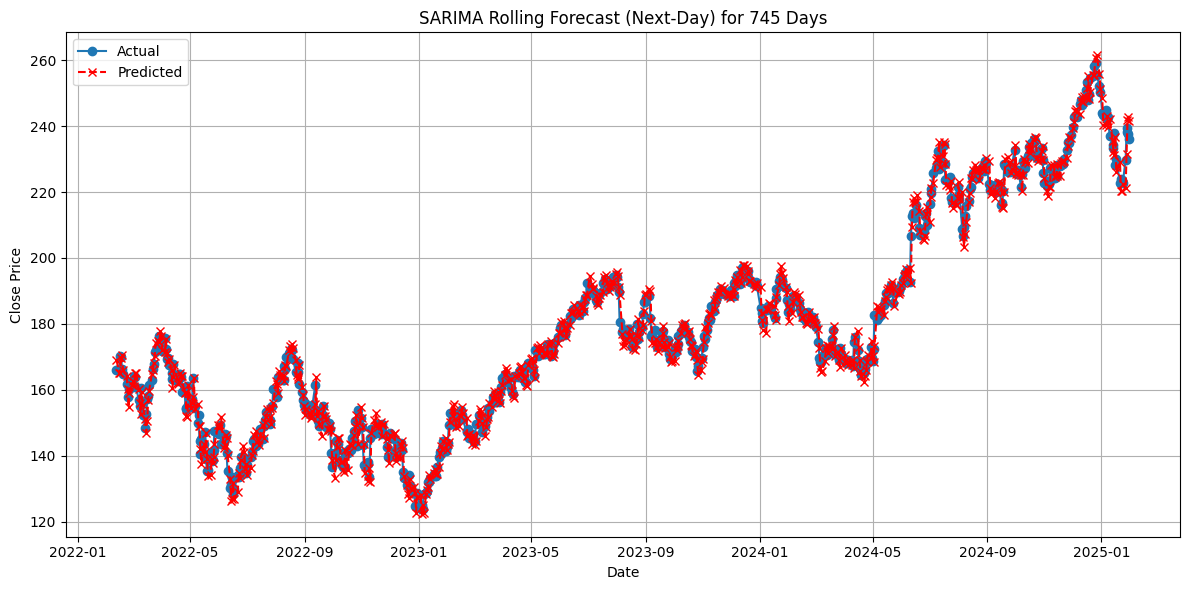

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(arima_test[:n_steps].index, actuals, label='Actual', marker='o')
plt.plot(arima_test[:n_steps].index, predictions, label='Predicted', linestyle='--', marker='x', color='red')
plt.title(f"SARIMA Rolling Forecast (Next-Day) for {len(arima_test)} Days")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
"""
 Can’t SARIMA be used for daily next-day close price prediction instead of weekly or monthly?
✅ Yes, absolutely. SARIMA can be used for next-day forecasts.

However, if you're using seasonality, make sure it's appropriate for daily data.

You’ve used:
seasonal_order = (2, 0, 2, 5)
This means:

You’re assuming weekly seasonality (because m=5 trading days/week).
That’s fine, but not strictly necessary for next-day prediction.

📌 If your next-day prediction doesn't benefit from seasonality, you might try:
seasonal_order = (0, 0, 0, 0)  # Equivalent to regular ARIMA
OR if you want to retain SARIMA, use:

seasonal_order=(P, D, Q, m) where m=5  # for weekly seasonality
SARIMA is flexible: use it for hourly, daily, weekly, monthly, etc., as long as your m (seasonal period) makes sense.

"""

In [ ]:
"""
Why is R² negative even though RMSE improved?
This is key. Let’s understand:

📌 R² (coefficient of determination) formula:
𝑅^2=1−RSS/TSS

RSS = Residual sum of squares = model error
TSS = Total sum of squares = variance from mean

➡️ If your model is worse than just predicting the mean, then RSS > TSS, and R² becomes negative.

🔍 Interpretation of your result:
SARIMA RMSE: 7.986863816973874
SARIMA R² Score: -0.9531378609954022
RMSE got better (compared to ARIMA), which is good.

But R² is strongly negative, which tells us:

✅ Your predictions deviate far from actual values, even if RMSE is numerically smaller.

❗ This might happen if:
You used n_steps = 30 but your arima_test had much more variance than your model could explain.
Or you're evaluating too long a range for a short-term model like SARIMA.
"""


#Applying Hybrid Model(SARIMA + XGBOOST) for next day's closing price

#Residual Calculation

In [ ]:
sarima_forecast_series = pd.Series(predictions, index=arima_test.index[:n_steps])
actual_series = pd.Series(actuals, index=arima_test.index[:n_steps])
residual_series = actual_series - sarima_forecast_series

In [ ]:
"""
sarima_forecast_series = pd.Series(predictions, index=arima_test.index[:n_steps])
🔹 What it does:
predictions: a list of values predicted by your SARIMA model, one step at a time, for n_steps days.
This line converts that list into a Pandas Series so it can be aligned with dates from the test set.

🧠 Why index=arima_test.index[:n_steps]?
This assigns the actual dates from your test set (same order) to your SARIMA predictions.
Ensures the forecast series is time-aligned with actual data.

actual_series = pd.Series(actuals, index=arima_test.index[:n_steps])
🔹 What it does:
actuals: list of real observed close prices from the test set, for the same n_steps.
This line wraps them into a Pandas Series using the same date index.

✅ Now both sarima_forecast_series and actual_series are time-aligned Series with the same index.

residual_series = actual_series - sarima_forecast_series
🔹 What it does:
Residual = Actual - Predicted
This line computes the difference between the true closing price and what SARIMA predicted — for each day.

🧠 Why is this important?
These residuals capture what SARIMA missed — the patterns SARIMA alone couldn’t explain.
You will now train an XGBoost model to learn and predict these residuals, using technical features like lagged prices.

In the final hybrid model, you'll do:
Final Forecast = SARIMA Prediction + XGBoost Residual Prediction

✅ Summary:
| Variable                 | Meaning                                 |
| ------------------------ | --------------------------------------- |
| `sarima_forecast_series` | SARIMA's daily predictions (as Series)  |
| `actual_series`          | Ground truth closing prices             |
| `residual_series`        | Errors SARIMA made (actual - predicted) |

"""

##Create Lag Features + SARIMA Forecast Feature

In [ ]:
def create_lag_features(series, lags=[1, 2, 3, 5, 10]):
    df = pd.DataFrame({'Close': series})
    for lag in lags:
        df[f'Close_lag{lag}'] = df['Close'].shift(lag)
    return df.dropna()

In [ ]:
"""
| Code                                                     | Purpose                                                                                                      |
| -------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| `def create_lag_features(series, lags=[1, 2, 3, 5, 10])` | Defines a reusable function to create lag features from a time series                                        |
| `df = pd.DataFrame({'Close': series})`                   | Wraps the given `series` (e.g., a Close price series) into a DataFrame                                       |
| `df[f'Close_lag{lag}'] = df['Close'].shift(lag)`         | For each lag value (like 1, 2, 3...), it creates a new column where the values are shifted by that many days |
| `return df.dropna()`                                     | Removes rows that have `NaN` values due to lagging at the beginning of the series                            |

✅ Part 2: Why are we doing this again if you already created lag features earlier?
You're absolutely right — you already created lag features in the full dataset (df_aapl):
for lag in range(1,6):
    df_aapl[f'Close_lag{lag}'] = df_aapl['Close'].shift(lag)

🔁 Reason for Recreating Lag Features:
| ✅ **Earlier Lag Features**                                                     | ✅ **Now in Hybrid Model**                                                                                                   |
| ------------------------------------------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------- |
| You applied lagging to the entire dataset (`df_aapl`) before train-test split. | Now you're working on a smaller time series slice (`arima_series`) and aligning it only with the **residuals** from SARIMA. |
| Used for general modeling like Linear Regression, LSTM, etc.                   | Used for **XGBoost to learn residuals**, so lag features must match residuals' time index.                                  |
| Includes all dates and may have missing alignment                              | Must perfectly align only with the dates for which residuals exist.                                                         |

✅ Summary:
| Concept           | Reason                                                                   |
| ----------------- | ------------------------------------------------------------------------ |
| Reusing lag logic | Yes, because it's simple and consistent                                  |
| Why redo?         | You need fresh lag features that **align only with residual timestamps** |
| Function benefit  | Makes lag generation reusable and modular for any model or time slice    |

"""

In [ ]:
"""
Why lags=[1, 2, 3, 5, 10]  we are using like this 1 2 3 5 10  why not like earlier where i had created range(1:6)?

Excellent observation! The choice between:
lags = [1, 2, 3, 5, 10] vs range(1, 6) (which is [1, 2, 3, 4, 5])
Depends on what you're trying to teach the model and how much past context you want it to learn from.

🔍 Let's compare the two choices:
| Version                           | Description                                   | Intent                                                  |
| --------------------------------- | --------------------------------------------- | ------------------------------------------------------- |
| `range(1, 6)` → `[1, 2, 3, 4, 5]` | Consecutive last 5 days                       | Good when short-term recent prices drive future price   |
| `[1, 2, 3, 5, 10]`                | Combination of near and slightly farther lags | Useful to give model mixed memory: short + medium range |


🧠 Why use [1, 2, 3, 5, 10] in Hybrid SARIMA + XGBoost?
Because:
SARIMA already captures time series trend and seasonality.
What’s left (the residuals) may be influenced by irregular patterns — like sudden price dips or rebounds from a few days ago (e.g., 5 or 10 days back).
Including lags like 5 and 10 gives XGBoost visibility into these slightly longer-term effects.
Think of it like giving XGBoost both “recent memory” (lags 1-3) and “distant memory” (lag 10).

You can try and check this
# Option A - Dense short-term memory
create_lag_features(arima_series, lags=[1,2,3,4,5])

# Option B - Short + Long-term
create_lag_features(arima_series, lags=[1,2,3,5,10])

"""

In [ ]:
lagged_df = create_lag_features(arima_series)
lagged_df = lagged_df.loc[residual_series.index.intersection(lagged_df.index)].copy()
residual_series = residual_series.loc[lagged_df.index]
lagged_df['residual'] = residual_series

In [ ]:
"""
lagged_df = create_lag_features(arima_series)
This creates a new DataFrame lagged_df containing:the original Close price series plus multiple lagged versions (like Close_lag1, Close_lag2, etc.)
This is the feature matrix (X) for training the residual-predicting XGBoost model.

lagged_df = lagged_df.loc[residual_series.index.intersection(lagged_df.index)].copy()
This aligns the lagged features with the residuals from the SARIMA model.

Why?
The residual_series was computed only for n_steps (e.g., last 30 dates).
But lagged_df may contain more rows (from the whole time series).
So we keep only those rows in lagged_df whose index is present in the residuals.

residual_series = residual_series.loc[lagged_df.index]
Now, to make sure both lagged_df and residual_series are perfectly aligned (same dates), this line trims the residual series to the same index as lagged_df.

lagged_df['residual'] = residual_series
Adds a new column 'residual' to the lagged_df — this is the target variable (y) that XGBoost will try to predict based on the lag features (X).

🎯 Summary (What is this block doing?)
| Step                         | Purpose                                     |
| ---------------------------- | ------------------------------------------- |
| Create `lagged_df`           | Features from previous close prices         |
| Align indices with residuals | So that features and target match date-wise |
| Add residuals as label       | Target for training XGBoost                 |

This sets up the supervised learning dataset where:
Input (X) = lag features
Output (y) = SARIMA residuals

"""

In [ ]:
"""
🔍 Step-by-step Explanation: lagged_df = lagged_df.loc[residual_series.index.intersection(lagged_df.index)].copy()
1. residual_series.index
This is the list of dates for which:
You have residuals (i.e., actual close - SARIMA forecast).

2. lagged_df.index
This is the list of dates for which:
You have lag features created from the original close price.

3. .intersection(...)
This finds the common dates present in both residual_series and lagged_df.

4. lagged_df.loc[...]
This selects only the rows in lagged_df where the index matches the common dates.

5. .copy()
This creates a copy of the sliced DataFrame to avoid "SettingWithCopyWarning" later.

💡 Why This is Needed:
After you create lag features, there are some NaN rows at the start (because shifting loses the first few rows).
And residuals are available only for the n_steps rolling SARIMA predictions. So not every row aligns.

This line ensures clean alignment between:
The features (lagged_df)
The target residuals (residual_series)
"""

##  Drop NaNs and Train Residual Model

In [ ]:
hybrid_df = lagged_df.dropna()
X = hybrid_df.drop(columns=['Close', 'residual'])
y = hybrid_df['residual']

In [ ]:
"""
🧠 What's Happening?
🔸 Step 1: hybrid_df = lagged_df.dropna()
Removes all rows with NaN values from lagged_df.
Why?
Lag features like Close_lag1, Close_lag2, etc., are created using .shift(), which naturally introduces NaNs for the first few rows.
We also join this with residuals, and that may introduce more NaNs.
We need a clean dataset for model training, so this line filters only complete rows (no missing values).

🔸 Step 2: X = hybrid_df.drop(columns=['Close', 'residual'])
Prepares your features (X) — the inputs to train the machine learning model.
Drops:
'Close': Original close price (we don’t want to directly feed this into residual prediction, because SARIMA already modeled it).
'residual': This is the target/output, not a feature.

✅ So X now contains only lag-based features: Close_lag1, Close_lag2, ..., Close_lag10
🔸 Step 3: y = hybrid_df['residual']
Extracts the target values (i.e., what the XGBoost model should learn to predict).
These are the residuals from the SARIMA forecast (i.e., the errors SARIMA made).
The model will learn to correct those SARIMA errors using patterns in the lag features.

🎯 Summary Table
| Variable    | Meaning                    | Contains                             |
| ----------- | -------------------------- | ------------------------------------ |
| `hybrid_df` | Cleaned DataFrame          | `Close`, `Close_lag1..N`, `residual` |
| `X`         | Input features for XGBoost | Only lag features                    |
| `y`         | Target to predict          | Residuals from SARIMA forecast       |

"""

In [ ]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb.fit(X, y)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
residual_preds = pd.Series(xgb.predict(X), index=X.index)

In [ ]:
"""
✅ What's Going On Here?
You are:
Using the trained XGBoost model (xgb) to:
Predict the residuals (errors that SARIMA made)
Converting those predictions into a Pandas Series so it aligns with your original data structure

🧠 Step-by-Step Breakdown
| Part             | Explanation                                                                                        |
| ---------------- | -------------------------------------------------------------------------------------------------- |
| `xgb.predict(X)` | Uses the trained XGBoost model to predict the residuals from the input features `X`                |
| `pd.Series(...)` | Wraps the predictions into a Pandas Series so it's easier to work with                             |
| `index=X.index`  | Keeps the original index from `X`, so the predictions line up correctly in time (i.e., with dates) |

🧪 Example
Let’s say:
X.index = ['2022-01-01', '2022-01-02', '2022-01-03']
xgb.predict(X) = [1.5, -2.0, 0.3]

residual_preds =
2022-01-01    1.5
2022-01-02   -2.0
2022-01-03    0.3
dtype: float64

✅ Now residual_preds is nicely aligned with dates, so you can add it to SARIMA forecasts to get the final hybrid forecast.
"""

#Final Prediction = SARIMA + Residual

In [ ]:
hybrid_preds = sarima_forecast_series.loc[residual_preds.index] + residual_preds
actual_final = actual_series.loc[residual_preds.index]

In [ ]:
"""
🔹 What's Going On?
You're aligning predictions and actual values to the same date index (based on residual_preds.index) so you can compare them and evaluate performance. Here’s how each line works:

🧠 Line 1: Hybrid Forecast Creation
hybrid_preds = sarima_forecast_series.loc[residual_preds.index] + residual_preds

➤ What this does:
Takes the SARIMA forecast (sarima_forecast_series)
Aligns it to the same dates as the residual predictions (from XGBoost)
Adds the predicted residuals to correct the SARIMA forecasts

➤ Why?
SARIMA alone may miss patterns. XGBoost helps "fix" that by learning from SARIMA’s past errors. You're adding back the estimated "error" to improve the forecast:

Hybrid Forecast = SARIMA Forecast + XGBoost Predicted Residual
🧩 Think of it like: SARIMA gives a rough estimate, and XGBoost corrects it.

actual_final = actual_series.loc[residual_preds.index]
➤ What this does:
Takes the true actual close prices
Ensures they are aligned to the same index (dates) as your hybrid predictions

➤ Why?
So you can compare the actual prices with your hybrid_preds and calculate metrics like RMSE or R²:

"""

# Evaluate Hybrid Model

In [ ]:
rmse = np.sqrt(mean_squared_error(actual_final, hybrid_preds))
r2 = r2_score(actual_final, hybrid_preds)
print("Hybrid Model (SARIMA Forecast + XGBoost Residual)")
print("RMSE:", rmse)
print("R² Score:", r2)

Hybrid Model (SARIMA Forecast + XGBoost Residual)
RMSE: 1.2846954905983345
R² Score: 0.99829804417518


#Plot Actual vs Predicted via (SARIMA + XGBOOST) for next day’s Price Predicitons

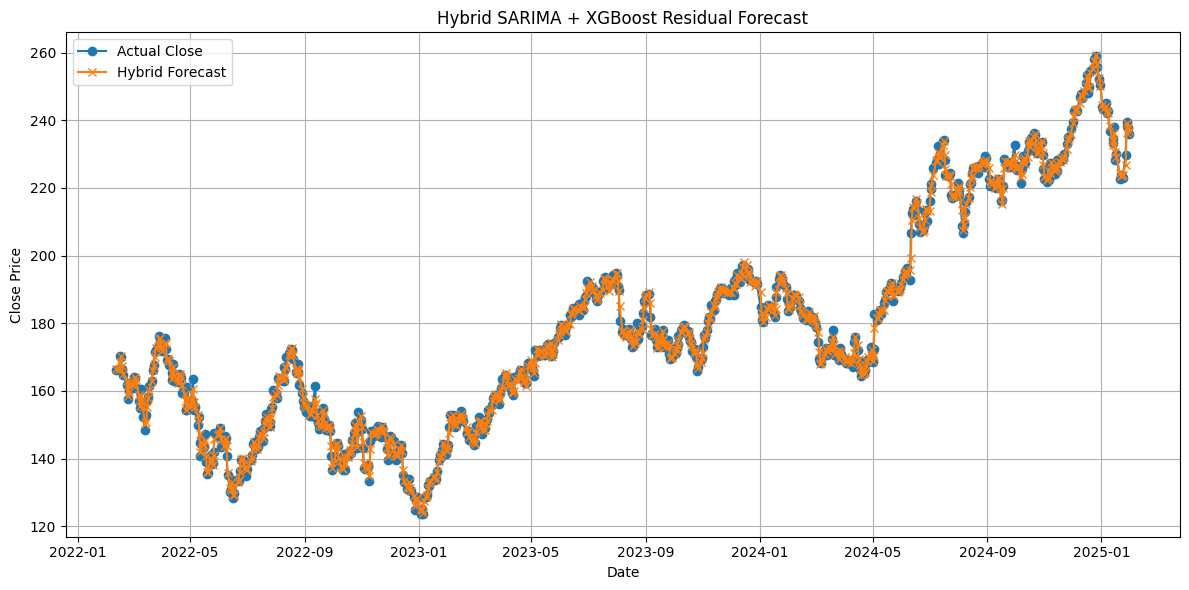

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(actual_final.index, actual_final, label='Actual Close', marker='o')
plt.plot(actual_final.index, hybrid_preds, label='Hybrid Forecast', marker='x')
plt.title("Hybrid SARIMA + XGBoost Residual Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
dt = '2024-12-16'
print(f"Date: {dt}")
print("Actual Close: ", actual_series.get(dt))
print("SARIMA Forecast: ", sarima_forecast_series.get(dt))
print("Hybrid Forecast: ", hybrid_preds.get(dt))

Date: 2024-12-16
Actual Close:  251.039993286133
SARIMA Forecast:  248.58457992533448
Hybrid Forecast:  250.1653778360248


## Breakdown Table for Multiple Specific Dates

In [ ]:
breakdown_df = pd.DataFrame({
    'Actual_Close': actual_series,
    'SARIMA_Forecast': sarima_forecast_series,
    'Residual_Actual': residual_series,
    'Residual_Predicted': residual_preds,
    'Hybrid_Forecast': hybrid_preds
}).round(2)

In [ ]:
specific_dates = ['2024-12-16', '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20']
print("\n📌 Breakdown for Selected Dates:")
print(breakdown_df.loc[breakdown_df.index.isin(specific_dates)])


📌 Breakdown for Selected Dates:
            Actual_Close  SARIMA_Forecast  Residual_Actual  \
Date                                                         
2024-12-16        251.04           248.58             2.46   
2024-12-17        253.48           251.66             1.82   
2024-12-18        248.05           255.21            -7.16   
2024-12-19        249.79           248.16             1.63   
2024-12-20        254.49           250.31             4.18   

            Residual_Predicted  Hybrid_Forecast  
Date                                             
2024-12-16                1.58           250.17  
2024-12-17                1.50           253.16  
2024-12-18               -5.65           249.56  
2024-12-19                1.62           249.78  
2024-12-20                3.95           254.26  


/tmp/ipython-input-69-1255973802.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  print(breakdown_df.loc[breakdown_df.index.isin(specific_dates)])


In [ ]:
print("\n📋 Full Breakdown Table (First 10 rows):")
print(breakdown_df.head(10))


📋 Full Breakdown Table (First 10 rows):
            Actual_Close  SARIMA_Forecast  Residual_Actual  \
Date                                                         
2022-02-11        166.13           169.18            -3.05   
2022-02-14        166.37           165.09             1.28   
2022-02-15        170.22           164.99             5.23   
2022-02-16        169.99           169.53             0.45   
2022-02-17        166.37           170.62            -4.25   
2022-02-18        164.81           166.14            -1.33   
2022-02-22        161.88           164.16            -2.28   
2022-02-23        157.69           160.18            -2.49   
2022-02-24        160.32           154.69             5.63   
2022-02-25        162.40           159.00             3.40   

            Residual_Predicted  Hybrid_Forecast  
Date                                             
2022-02-11               -2.59           166.59  
2022-02-14                1.41           166.50  
2022-02-15    

#Tabular Comparison of Actual vs Predicted from All Models for next day’s Price Predicitons

In [ ]:
# Tuning and storing predictions from regression models
reg_preds = {}

for name, reg in regressors.items():
   # print(f"Tuning: {name}")
    if reg["params"]:
        grid = GridSearchCV(reg["model"], reg["params"], cv=5, scoring='neg_root_mean_squared_error')
        grid.fit(X_train, y_train_reg)
        best_model = grid.best_estimator_
    else:
        best_model = reg["model"]
        best_model.fit(X_train, y_train_reg)

    y_pred = best_model.predict(X_test)
    reg_preds[name] = y_pred
    print(f"{name} - RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred)):.4f}, R² Score: {r2_score(y_test_reg, y_pred):.4f}")

Linear Regression - RMSE: 2.9171, R² Score: 0.9913
Random Forest - RMSE: 27.7901, R² Score: 0.2064
XGBoost - RMSE: 27.1329, R² Score: 0.2435


In [ ]:
# Use the correct true target for multivariate LSTM
additional_models = {
    "Univariate_LSTM": lstm_pred,
    "Multivariate_LSTM": pred_mv,
    "ARIMA": arima_forecast.values,
    "SARIMA": predictions,
    "Hybrid(SARIMA + XGBoost)": hybrid_preds
}


true_values_map = {
    "Univariate_LSTM": y_test_actual,        # inverse scaled y_test_lstm
    "Multivariate_LSTM": true_mv,            # inverse scaled y_test_mv
    "ARIMA": y_test_reg[-len(arima_forecast):],  # align to forecast
    "SARIMA": actuals , # align to forecast
    "Hybrid(SARIMA + XGBoost)": actual_final
}

for name, preds in additional_models.items():
    y_true = true_values_map[name]
    min_len = min(len(preds), len(y_true))
    print(f"{name} - RMSE: {np.sqrt(mean_squared_error(y_true[-min_len:], preds[-min_len:])):.4f}, R² Score: {r2_score(y_true[-min_len:], preds[-min_len:]):.4f}")


Univariate_LSTM - RMSE: 4.5186, R² Score: 0.9792
Multivariate_LSTM - RMSE: 4.2792, R² Score: 0.9722
ARIMA - RMSE: 32.5199, R² Score: -0.0868
SARIMA - RMSE: 3.2446, R² Score: 0.9891
Hybrid(SARIMA + XGBoost) - RMSE: 1.2847, R² Score: 0.9983


In [ ]:
# 1. Define consistent length to ensure all predictions are trimmed to the same final length (use min_len):
# Get actual lengths
len_uni_lstm = len(lstm_pred)
len_multi_lstm = len(pred_mv)
len_arima = len(arima_forecast.values)
len_sarima = len(predictions)
len_rf = len(reg_preds['Random Forest'])
len_lr = len(reg_preds['Linear Regression'])
len_xgb = len(reg_preds['XGBoost'])
len_test = len(test)
len_hybrid =len(hybrid_preds)

# Find minimum common length
min_len = min(len_uni_lstm, len_multi_lstm, len_arima,len_sarima, len_rf, len_lr, len_xgb, len_test,len_hybrid)

print(f"\n📏 Common comparison length = {min_len}\n")


📏 Common comparison length = 367



In [ ]:
#Create comparison DataFrame using final `test` slice
comparison_df = test.iloc[-min_len:][['Date', 'Close']].reset_index(drop=True).copy()
comparison_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

In [ ]:
# 3. Add each model's predictions trimmed to min_len
for name, pred in reg_preds.items():
    comparison_df[f'Predicted_{name}'] = pred[-min_len:]

comparison_df['Predicted_Univariate_LSTM'] = lstm_pred[-min_len:]
comparison_df['Predicted_Multivariate_LSTM'] = pred_mv[-min_len:]
comparison_df['Predicted_ARIMA'] = arima_forecast.values[-min_len:]
comparison_df['Predicted_SARIMA'] = predictions[-min_len:]
comparison_df['Predicted_Hybrid(SARIMA + XGBoost)'] = hybrid_preds[-min_len:].values


# Round and display
comparison_df = comparison_df.round(2)
print(comparison_df.head(10))

        Date  Actual_Close  Predicted_Linear Regression  \
0 2023-08-15        176.35                       176.69   
1 2023-08-16        175.48                       175.65   
2 2023-08-17        172.92                       173.37   
3 2023-08-18        173.41                       173.63   
4 2023-08-21        174.75                       175.03   
5 2023-08-22        176.13                       176.31   
6 2023-08-23        180.00                       179.99   
7 2023-08-24        175.29                       175.87   
8 2023-08-25        177.51                       177.55   
9 2023-08-28        179.08                       179.64   

   Predicted_Random Forest  Predicted_XGBoost  Predicted_Univariate_LSTM  \
0                   169.20         172.149994                     176.24   
1                   169.63         172.339996                     175.80   
2                   168.88         172.910004                     174.99   
3                   168.77         172.520004 

In [ ]:
comparison_df.to_csv('/content/drive/My Drive/Stock Price Prediction Project/DataSet/next_day_predicted_price_comparison.csv', index=False)

#Plot Actual vs Predicted (Using All Models Output) for next day’s Price Predicitons

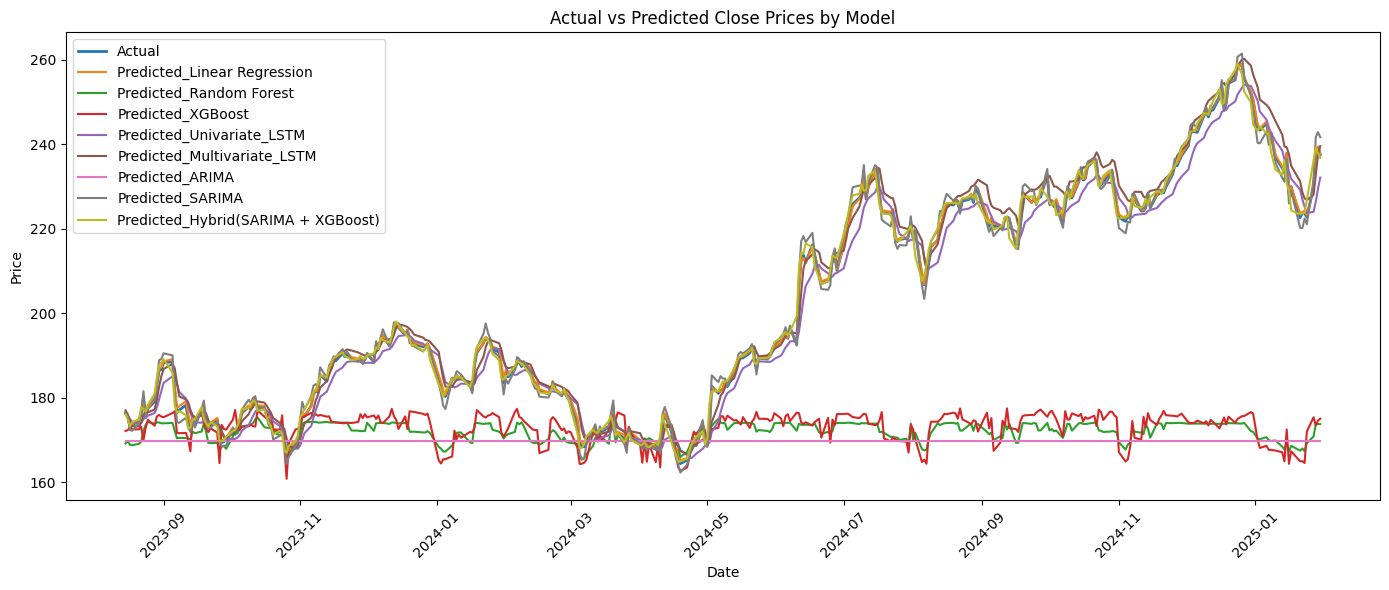

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(comparison_df['Date'], comparison_df['Actual_Close'], label='Actual', linewidth=2)
for col in comparison_df.columns:
    if 'Predicted' in col:
        plt.plot(comparison_df['Date'], comparison_df[col], label=col)

plt.legend()
plt.title('Actual vs Predicted Close Prices by Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Side by Side Plot for Actual vs Predicted (Using All Models Output) for next day’s Price

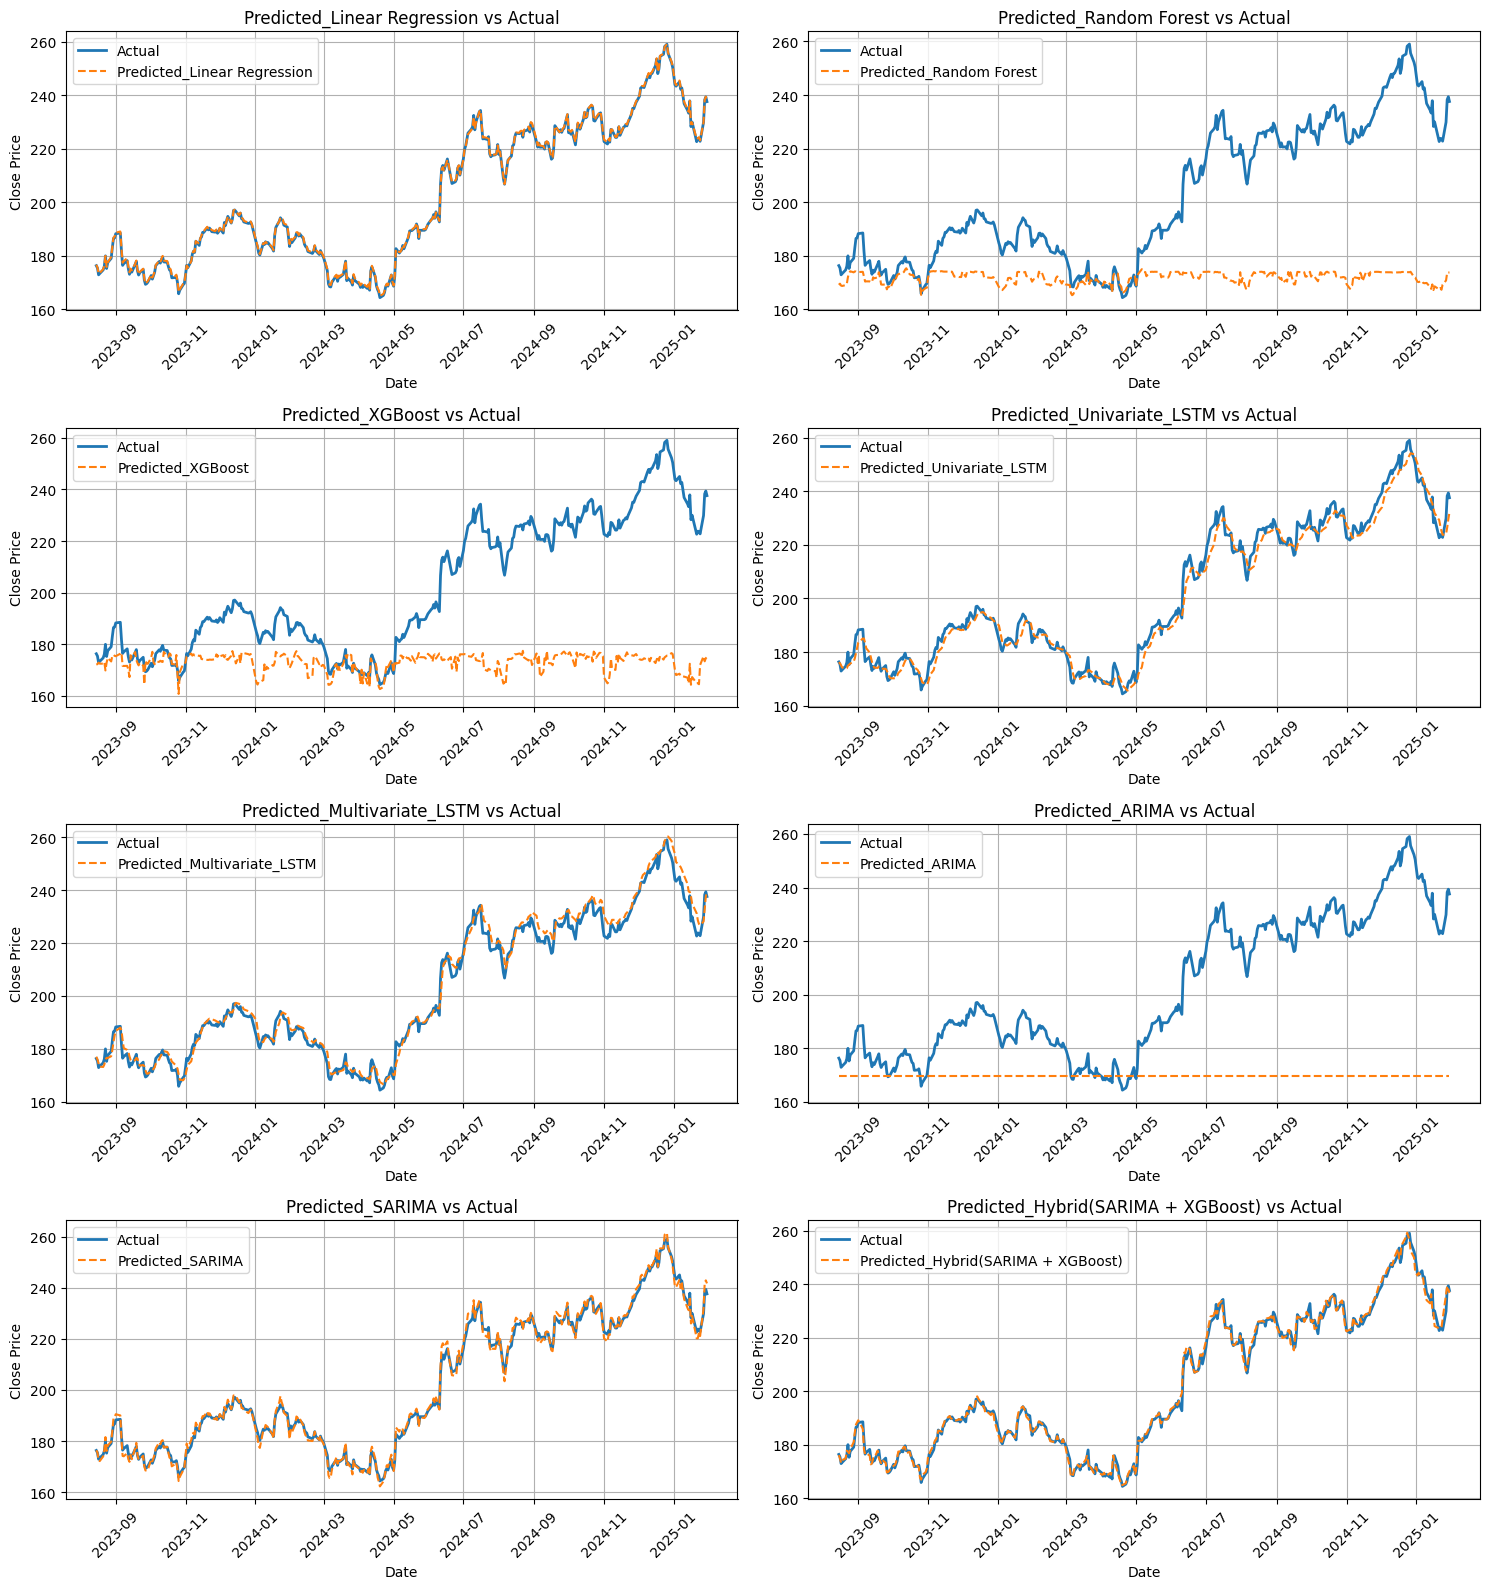

In [ ]:
# Extract prediction columns
model_cols = [col for col in comparison_df.columns if 'Predicted' in col]
n_models = len(model_cols)

# Set up subplot grid
n_cols = 2  # you can change to 3 if you prefer
n_rows = (n_models + n_cols - 1) // n_cols

plt.figure(figsize=(15, 4 * n_rows))

for idx, model_col in enumerate(model_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    plt.plot(comparison_df['Date'], comparison_df['Actual_Close'], label='Actual', linewidth=2)
    plt.plot(comparison_df['Date'], comparison_df[model_col], label=model_col, linestyle='--')
    plt.title(f'{model_col} vs Actual')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Display what's being trimmed (if any)
print("🔍 Trimmed Predictions Summary:")
print(f"  Actual values              : {len_test} ➜ {min_len} | Dropped: {len_test - min_len}")
print(f"  Univariate LSTM            : {len_uni_lstm} ➜ {min_len} | Dropped: {len_uni_lstm - min_len}")
print(f"  Multivariate LSTM          : {len_multi_lstm} ➜ {min_len} | Dropped: {len_multi_lstm - min_len}")
print(f"  ARIMA                      : {len_arima} ➜ {min_len} | Dropped: {len_arima - min_len}")
print(f"  Random Forest              : {len_rf} ➜ {min_len} | Dropped: {len_rf - min_len}")
print(f"  Linear Regression          : {len_lr} ➜ {min_len} | Dropped: {len_lr - min_len}")
print(f"  XGBoost                    : {len_xgb} ➜ {min_len} | Dropped: {len_xgb - min_len}")
print(f"  SARIMA                     : {len_sarima} ➜ {min_len} | Dropped: {len_sarima - min_len}")
print(f"  Hybrid(SARIMA + XGBoost)   : {len_hybrid} ➜ {min_len} | Dropped: {len_hybrid - min_len}")

🔍 Trimmed Predictions Summary:
  Actual values              : 742 ➜ 30 | Dropped: 712
  Univariate LSTM            : 733 ➜ 30 | Dropped: 703
  Multivariate LSTM          : 367 ➜ 30 | Dropped: 337
  ARIMA                      : 745 ➜ 30 | Dropped: 715
  Random Forest              : 742 ➜ 30 | Dropped: 712
  Linear Regression          : 742 ➜ 30 | Dropped: 712
  XGBoost                    : 742 ➜ 30 | Dropped: 712
  SARIMA                     : 30 ➜ 30 | Dropped: 0
  Hybrid(SARIMA + XGBoost)   : 30 ➜ 30 | Dropped: 0


In [ ]:
"""
🔍 Is trimming predictions to match the shortest one logically correct?
Yes, but with conditions. It's a practical and widely used approach in machine learning projects only when:
You want a fair comparison of multiple models on the same set of test dates.
Each model’s predictions are for overlapping parts of the test data (even if the models were trained or shaped slightly differently).
The "extra" predictions are not fundamentally different in distribution (e.g., one model doesn't predict future dates the others never saw).

⚠️ But when is it not advisable?
Trimming becomes logically incorrect if:
One model (say LSTM) predicts values beyond the test window others are using (e.g., true next-day prediction vs. pseudo-hindsight).
The test data or sequence alignment is shifted differently between models.
You need every available forecast for production or business decisions — not just comparison.

✅ Your Scenario: Is trimming justified?
Let’s look at your situation:

| ✅ Criteria                              | Applies?                                         |
| --------------------------------------- | ------------------------------------------------ |
| All models are evaluated on test data?  | ✅ Yes                                            |
| You want to compare their predictions?  | ✅ Yes                                            |
| Models are aligned to the same dates?   | ✅ Yes, after trimming                            |
| Models give slightly different lengths? | ✅ Yes (1–2 extra due to rounding, scaling, etc.) |


🟢 Conclusion:
Yes, it's logically valid in your case to trim to the shortest length for building a consistent comparison_df.
It’s a small tradeoff for correct indexing, fair model evaluation, and clean plotting.

"""

In [ ]:
"""
✅ Summary of Results
| Model                   | RMSE ↓     | R² Score ↑ | Performance Summary                                                |
| ----------------------- | ---------- | ---------- | ------------------------------------------------------------------ |
| **Linear Regression**   | 2.9171     | 0.9913     | Excellent baseline.                                                |
| **Random Forest**       | 27.7901    | 0.2064     | Underfitting. Poor result.                                         |
| **XGBoost**             | 27.1329    | 0.2435     | Also underfitting. Likely missing temporal/lag structure.          |
| **Univariate LSTM**     | 4.1828     | 0.9822     | Good. Slightly behind regression.                                  |
| **Multivariate LSTM**   | 4.2792     | 0.9722     | Weaker than univariate LSTM. Could need tuning or better features. |
| **ARIMA**               | 32.5199    | -0.0868    | Very poor. Likely model not capturing pattern (non-stationarity?). |
| **SARIMA**              | 3.2446     | 0.9891     | Strong. Much better than ARIMA. Seasonality helps.                 |
| **Hybrid (SARIMA+XGB)** | **1.2847** | **0.9983** | ★ Best. Excellent synergy. Captures residual patterns well.        |

🔍 Key Takeaways
Best Model:
Your Hybrid SARIMA + XGBoost model performs the best both in terms of RMSE and R² — very close to perfect predictions. You’ve clearly modeled both trend + seasonal + residual structures well.

Why Linear Regression Did Well:
Surprisingly, linear regression is almost as good, which likely means your underlying series has strong linear trend + possibly lagged correlation that linear regression captures well
(likely through features like lag_1, lag_2, etc.).

Why XGBoost / Random Forest Struggled:
These models don’t handle time-series well unless lag features and time indices are carefully engineered. They likely didn’t “see” temporal dependencies without them.

LSTM:
Your Univariate LSTM is performing quite well — a bit behind regression, but still robust.
The Multivariate LSTM likely suffers from noisy input features or poor scaling. Revisit feature selection.

ARIMA vs SARIMA:
ARIMA performed poorly (negative R²), likely due to missing seasonality or overfitting.
SARIMA's strong performance shows that your series has seasonal structure (5-day trading week?).

"""